# **Problématique : Quels sont les déterminants du salaire en NBA sur les 25 dernières années ?**

L'objectif de l'étude menée dans le cadre de la matière *Python pour la Data Science* a été d'identifier les déterminants du salaire en NBA avec les données des 25 dernières années. Plus particulièrement, les salaires en NBA sont critiqués car jugés trop élevés, ou parfois trop faibles selon les cas. On va donc chercher à voir si les performances sur le terrain des joueurs ont un impact significatif sur l'évolution de leur salaire au cours de leur carrière.

Pour cela, nous avons utilisé la bibliothèque *nba_api*, développée par la NBA afin de récupérer toutes les données sur les joueurs / équipes pour les 25 dernières saisons. On a également développé un outil de scraping via Selenium pour récupérer les salaires des joueurs pour chaque saison, ainsi que les différents titres individuels qu'ils ont pu remporter (MVP sur une saison par exemple). Toutes ces données sont ensuite enregistrées dans le dataframe `merged_data.csv`.   

---

# 1 - Construction de la base de données

Toutes les données collectées sont enregistrées dans le dossier `./data`. La base de données contenant toutes les données pour notre analyse, `merged_data.csv`, est construite via la fonction `scrape_all_data()` qui utilise elle même plusieurs fonctions pour aller chercher des données à des endroits différents :


---

**a - Sources de données**

- Statistiques des joueurs (1996–2024) : récupérées via l'API `nba_api`

- Statistiques des équipes (1996–2024) : récupérées via l'API `nba_api`

- Salaires des joueurs (2000–2025) : récupérées via le scraping du site ESPN (avec **BeautifulSoup**)

- MVP NBA : récupérées via le scraping du site Basketball Reference (récupérés via **Selenium**)

Toutes ces données sont enregistrées de manière individuelle sous la forme de fichiers `.csv`, organisés selon une arborescence hiérarchique par saison pour améliorer la lisibilité du projet. Concrètement :

- On a un dossier par saison (ex: `2023-24/`, `2022-23/`, etc.)
- À l'intérieur de chaque dossier saison, on a 3 sous-dossiers :
  - `Regular_Season/` : contient 2 fichiers csv (statistiques joueurs + équipes en saison régulière)
  - `Salaries/` : contient 1 fichier csv (salaires des joueurs pour cette saison)
- Au même niveau que les dossiers de saison, on a un dossier `MVP` contenant un fichier csv avec l'historique des MVP par saison.

---

**b - Processus d'aggrégation des données (via la fonction `merge_data`)**


Pour faciliter l'analyse des données, on aggrege nos données dans un seul et même fichier csv. La fusion s'effectue par défaut pour les saisons 2000 / 2025. Celle-ci se fait en plusieurs étapes :

- Merge des fichiers joueurs + salaires : fusion sur `PLAYER_NAME = Player`
- Ajout du `W_PCT` pour chaque joueur et pour chaque saison : récupération du `TEAM_W_PCT` depuis les statistiques d'équipes
- Tri chronologique : par `PLAYER_ID` et `Year`


---

**c - Variables d'intérêt créées**


A partir des données aggrégées, on crée quelques variables pour augmenter la qualité de notre analyse. Tout d'abord on crée une variable qui ajuste le salaire des joueurs à l'inflation pour donner du sens à la comparaison des salaires en 2000 et 2025 par exemple. On ajoute également une variable binaire `Changed_team` indiquant si un joueur a changé d'équipe d'une saison à l'autre (qui peut avoir un impact sur le salaire). Enfin, on crée la variable `YOE` indiquant l'ancieneté du joueur en NBA.

- `adjusted_salary` : Salaire ajusté à l'inflation (base 2024)  
  - Utilise des facteurs d'inflation du *Bureau of Labor Statistics*

- `next_adjusted_salary` : Salaire ajusté de l'année suivante (sera utilie pour la modélisation)
  - Créé via `groupby('PLAYER_ID').shift(-1)`

- `Changed_team` : Indicateur binaire (0/1) de changement d'équipe

- `YOE` (Years Of Experience) : Nombre de saisons jouées

Commençons par importer et agréger toutes ces données dans une même base de données (fichier .csv) :

In [1]:
from src.build_nba_bdd import scrape_all_data

# Création de la base de données (combine étapes a-, b- et c-) (dure 5min environ)

# PAS NECESSAIRE ICI, LE PROJET GITHUB CONTIENT DEJA LA BDD 'merged_nba.csv' NECESSAIRE POUR LE RESTE DU CODE

scrape_all_data(season_types=['Regular Season'])

Récupération des statistiques de 1996--3 à 2024-25
Types de saison: Regular Season
Total: 29 fichiers à créer

[1/29] 1996-97 - Regular Season
Récupération des statistiques de la saison 1996-97...

Fichier './data/1996-97/Regular_Season\nba_players_stats_1996-97_Regular_Season.csv' créé avec succès!
[2/29] 1997-98 - Regular Season
Récupération des statistiques de la saison 1997-98...

Fichier './data/1997-98/Regular_Season\nba_players_stats_1997-98_Regular_Season.csv' créé avec succès!
[3/29] 1998-99 - Regular Season
Récupération des statistiques de la saison 1998-99...

Fichier './data/1998-99/Regular_Season\nba_players_stats_1998-99_Regular_Season.csv' créé avec succès!
[4/29] 1999-00 - Regular Season
Récupération des statistiques de la saison 1999-00...

Fichier './data/1999-00/Regular_Season\nba_players_stats_1999-00_Regular_Season.csv' créé avec succès!
[5/29] 2000-01 - Regular Season
Récupération des statistiques de la saison 2000-01...

Fichier './data/2000-01/Regular_Season\nba

In [1]:
import pandas as pd

# Chargement de la base de données contenant les infos + performances des joueurs

df = pd.read_csv('./data/merged_data.csv')

print(f"Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")

Dataset chargé: 9846 lignes, 78 colonnes


---

# 2 - Statistiques Descriptives

---

## 2.1 Données utilisées

Nous avons construit la base de données `merged_data.csv` contenant plus de 10000 données (1 donnée = performances et informations d'un joueur sur une saison) ainsi que 78 variables.

Cette base de données est très pertinente pour cette étude car, grâce aux données scrapées et aux variables crées, on a à notre disposition un nombre important de statistiques de performance des joueurs, les plus notables étant :  
  
**adjusted_salary :** *Salaire brut sur une saison, ajusté pour permettre la comparaison entre les différentes saisons*  
**PTS :** *Nombre de points inscrits par match en moyenne*  
**REB :** *Nombre de rebonds captés par match en moyenne*  
**AST :** *Nombre de passes décisives effectuées par match en moyenne*  
**STL :** *Nombre d'interceptions effectuées par match en moyenne*  
**BLK :** *Nombre de tirs contrés par match en moyenne*  
**PLUS_MINUS :** *Différence entre les points inscrits et encaissés par l'équipe lorsque le joueur est présent sur le terrain en moyenne*  
**NBA_FANTASY_PTS :** *Points attribués aux performances des joueurs, sur une plateforme permettant de faire un concours de pronostic durant la saison*  
**FGM :** *(Field Goal Made) le nombre de tirs réussis en moyenne par match*  
**TD3 :** *Nombre de Triple-Doubles réussis sur une saison (càd + de 10 unités dans 3 catégories statistiques parmi ((PTS, REB, AST, STL, BLK)*
  
**XXX_RANK :** *Classement d'un joueur sur une saison régulière dans la catégorie statistique XXX (PTS, REB, AST, STL, BLK,...)*  

**YOE :** *Nombre d'années passées à jouer dans la ligue (Ancienneté)* 

---

# 2.2 Evolution du salaire v.s les principales métriques de performance

Dans cette section, on s'intéresse à l'évolution des salaires en fonction des 5 métriques de performances principalement regardées (par le grand public) en NBA, ainsi que le temps de jeu.

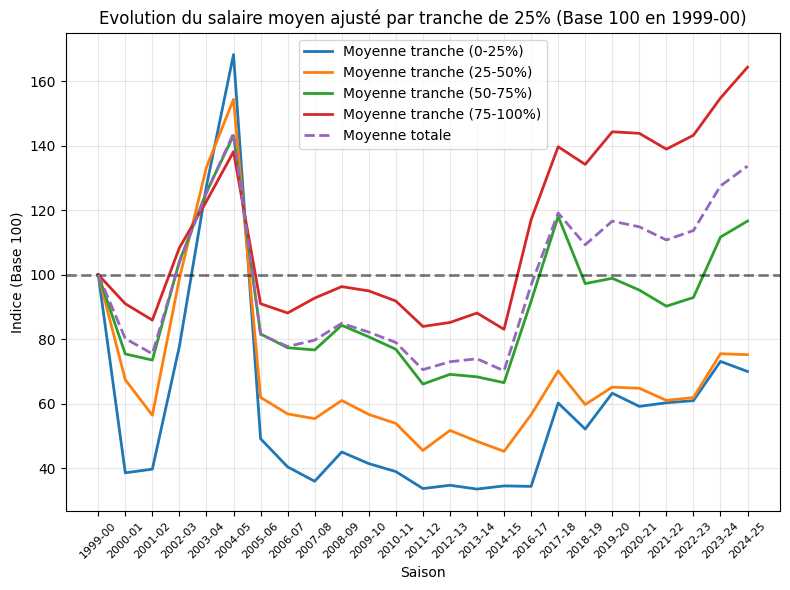

In [2]:
from src.plot_func import plot_salary_quartiles_evolution

plot_salary_quartiles_evolution(data=df, season_start='1999-00')

Avant toute chose, on remarque des salaires moyens très volatiles entre la saison 99-00 et la saison 04-05. Ceci peut être expliqué par le faible nombre de salaires que nous avons pour ces années (150 environ) contre plus de 450 pour le reste de la période. On imagine donc qu'on n'a pas accès à la totalité des salaires de ces saisons, donc nous nous intéresserons seulement à l'évolution tendentielle à partir de 2005-06 dans cette section.

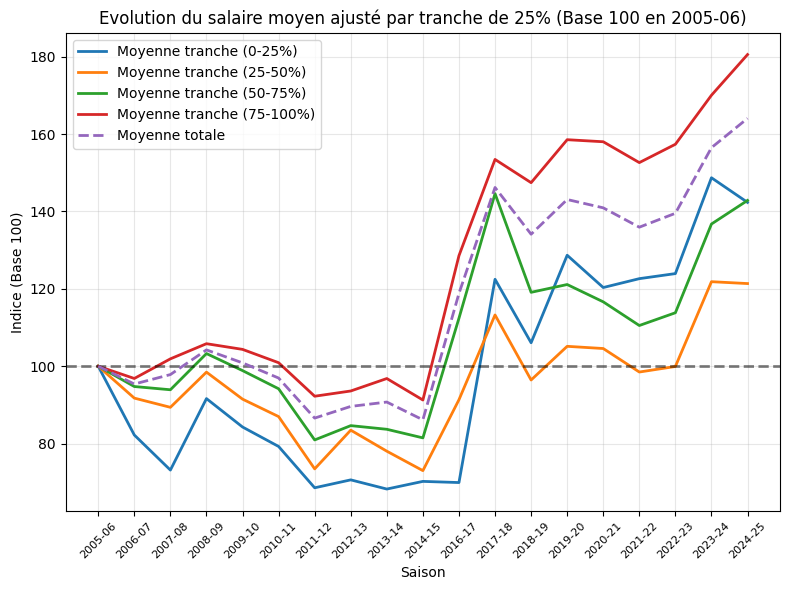

In [3]:
plot_salary_quartiles_evolution(data=df, season_start='2005-06')

Nous constatons ici, que pendant une dizaine d'années le salaire moyen avait une tendance baissière, surtout pour les tranches de salaires les plus faibles. A partir de la saison 2014-15, on a pu voir les salaires des tranches les plus élevées exploser, avec le salaire moyen des tranches les plus faibles qui ont suivi quelques saisons plus tard. 

Comparé au salaire moyen en 2005, les salaires moyens (ajustés à l'inflation) ont augmenté de plus de 60%. Cette hausse est fortement guidée par la l'augmentation exceptionnelle des salaires moyens des 25% de joueurs les mieux payés (80%), alors que la tranche des 25% à 50% n'a vu son salaire moyen n'augmenter "que" de 20%. Les Superstars sont donc les joueurs ayant le plus profité de la hausse des salaires.

Maintenant, regardons si cette hausse généralisée des salaires concorde avec une hausse des performances moyennes.

### Evolution des 5 statistiques majeures (PTS, REB, AST, STL, BLK)

In [4]:
df['total_minutes'] =  df['MIN'] * df['GP']
time_played_season = df.groupby('Season')['total_minutes']    # Nombre de minutes jouées par saison en moyenne

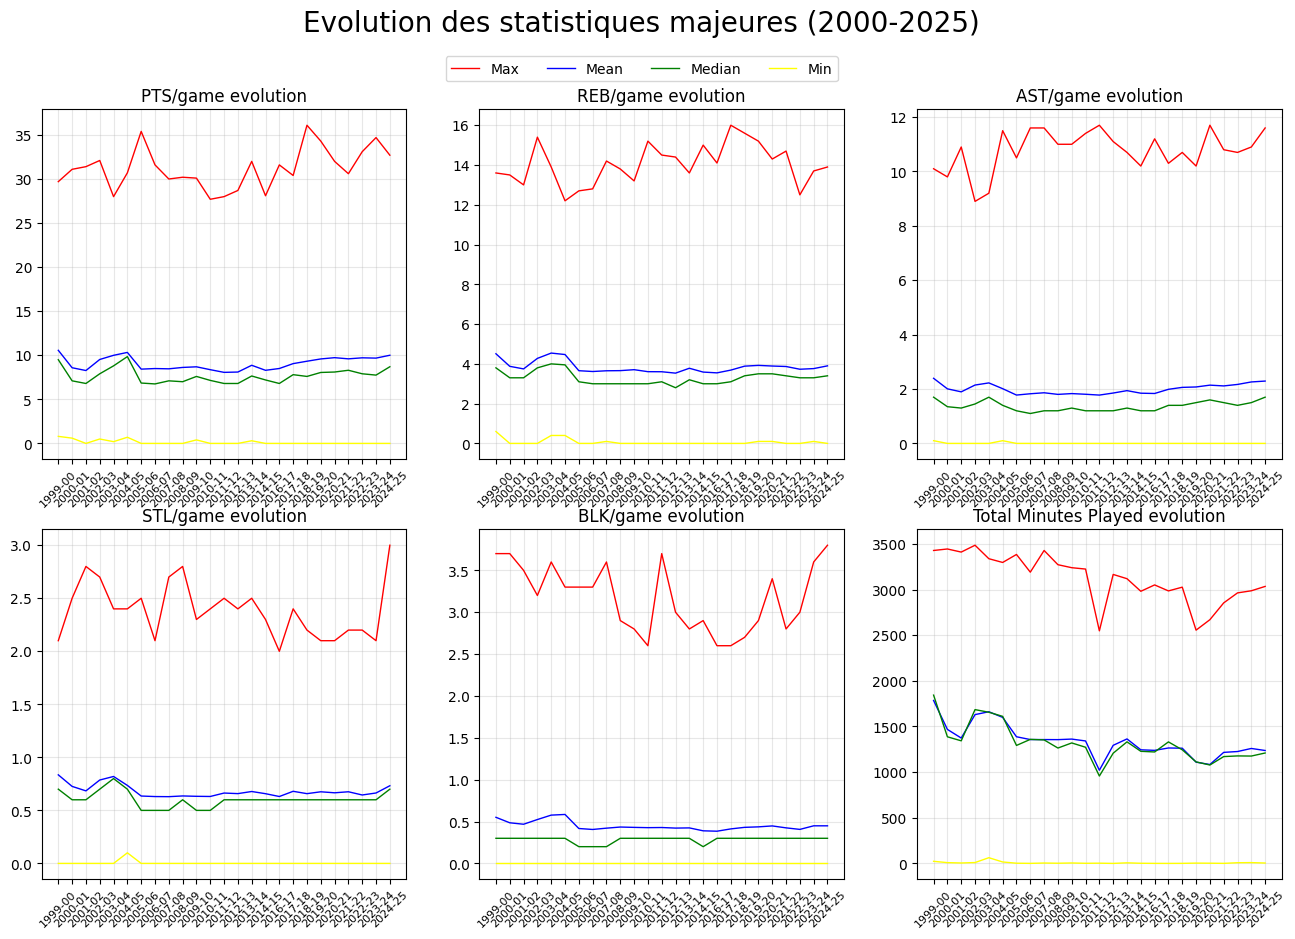

In [5]:
import matplotlib.pyplot as plt
from src.plot_func import plot_major_stats_evolution

plot_major_stats_evolution(df)

On n'observe pas d'augmentation massive d'aucune des 5 statistiques principales qui semble pouvoir totalement expliquer la hausse des salaires. Les joueurs ne semblent pas être significativement meilleurs qu'il y a 20 ans. Pourtant, comme on peut le voir sur la première figure, le salaire moyen ajusté à l'inflation a augmenté en 20 ans,surtout à partir de 2015. 

On pourrait alors penser que le temps de jeu des joueurs a augmenté, pouvant expliquer l'augmentation du salaire moyen. Mais là encore, aucune évolution notable du temps de jeu, il semble même plutôt diminuer. La diminution soudaine des minutes totales jouées en 2011-2012, s'explique par le lockout (~ grève des joueurs), du 1er juillet au 8 décembre 2011, qui a amputé cette saison de ses 16 premiers matchs.

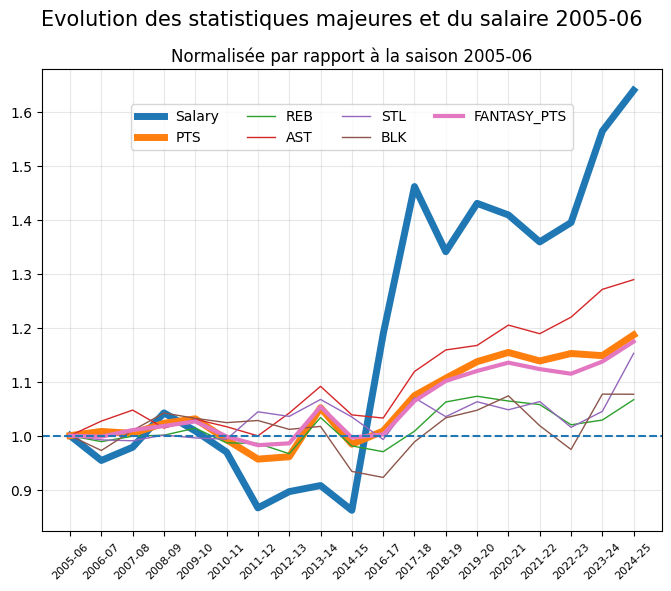

In [6]:
from src.plot_func import plot_major_stats_with_salary

plot_major_stats_with_salary(df, season_start='2005-06')

Cette visualisation confirme l'intuition données par les graphiques précédents : alors que le salaire moyen a augmenté de 60% depuis 2005, les principales statistiques de performance des joueurs sur le terrain n'ont augmenté que de 7% à 30% en fonction de la métrique.

### Evolution des salaires en fonctions des performances

In [7]:
from src.plot_func import plot_desc_salary_cont
from src.plot_func import plot_desc_salary

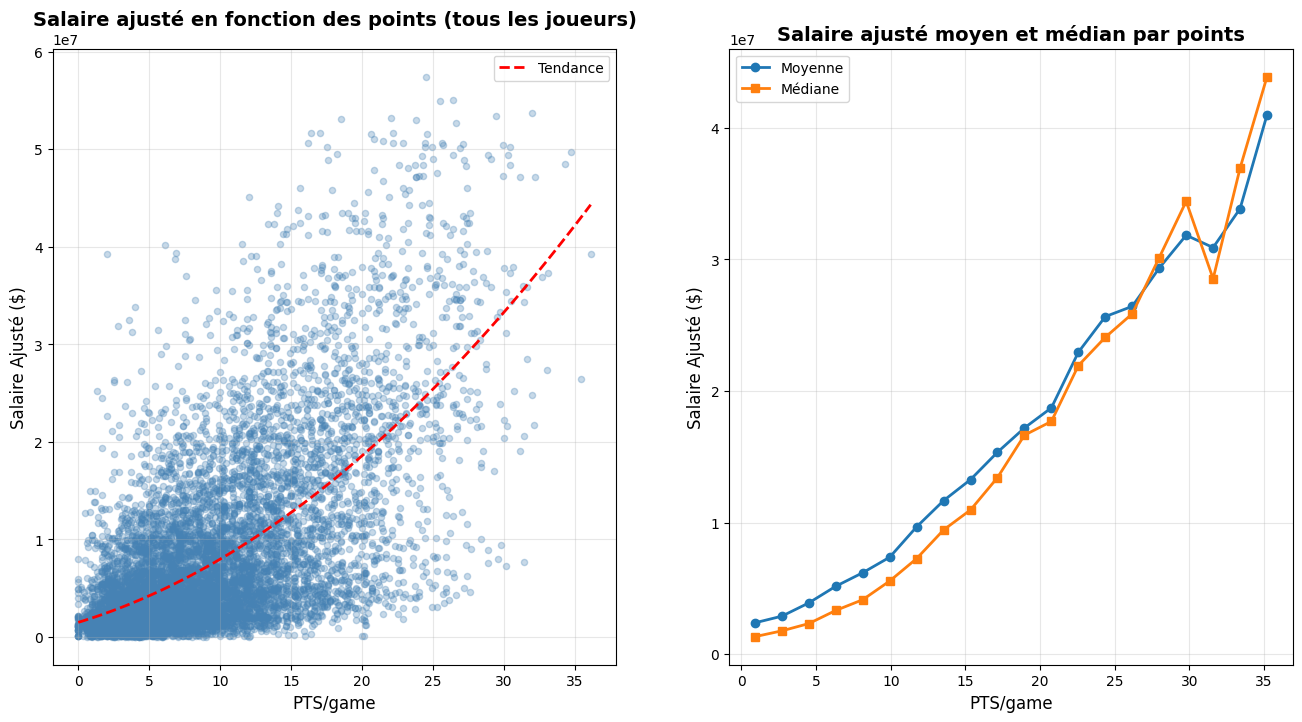

In [8]:
plot_desc_salary_cont('PTS' , 'points' , nb_inter = 20)

Comme notre intuition laissait à penser, les salaires évoluent positivement en fonction des points inscrits. Cette évolution n'est pas constante, en passant la barre des 25 points par match, les salaires évoluent encore plus fortement pour chaque points supplémentaires inscrits par match. Le graphique de droite semble montrer qu'inscire un 31eme points par match a un effet négatif sur le salaire médian, ce qui ne semble pas cohérent, mais qui peut être expliqué par le faible nombre de joueurs à plus de 30 points par match.  

Cependant le nuage de points présente une dispersion importante, alors malgré une tendance claire, estimer le salaire d'un joueur uniquement à partir des points inscrits semble impossible.  

On cherche alors une variable qui tienne compte de plus de paramètres que simplement les points inscrits. On utilise alors un proxy de la performance globale : NBA_FANTASY_PTS. Cette variable attribue des "fantasy points" à chaque action positive effectué par un joueur (dans la version actuelle): 1 pour chaque point (réels) inscrit, 1 pour chaque rebond, 2 par passe décisive, 3 par contre et enfin 3 par interception

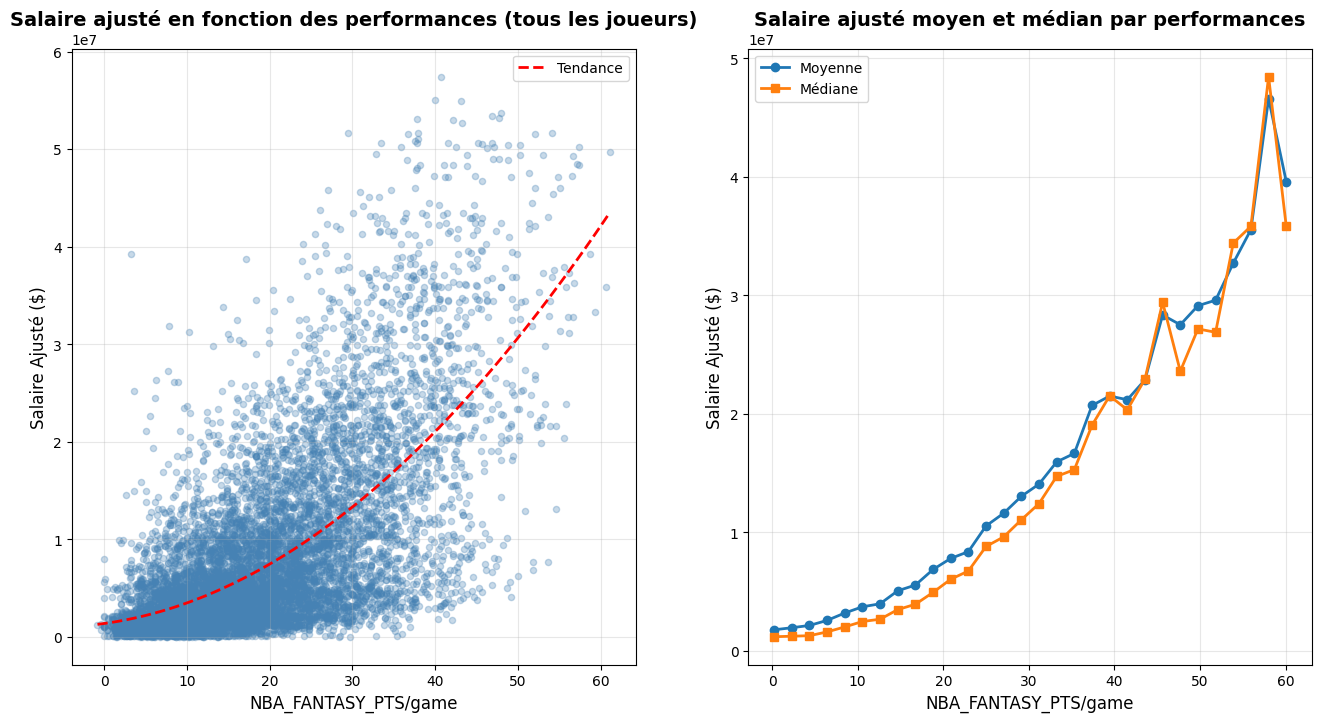

In [9]:
plot_desc_salary_cont('NBA_FANTASY_PTS' , 'performances', nb_inter = 30)

Intéressons nous à l'évolution des salaires en fonction de métriques autres que la performance.

---

# 2.3 Evolution du salaire v.s l'expérience, le poste occupé et l'équipe

### Evolution des performances en fonction de l'exprérience

Dans la grande majorité des domaines on observe une corrélation entre expérience et rémunération, car on apprends le métier au cours des années et on devient alors plus performants. Cela ne semble pas aussi simple dans le sport de haut niveau, car le corps fatigue avec les années. 

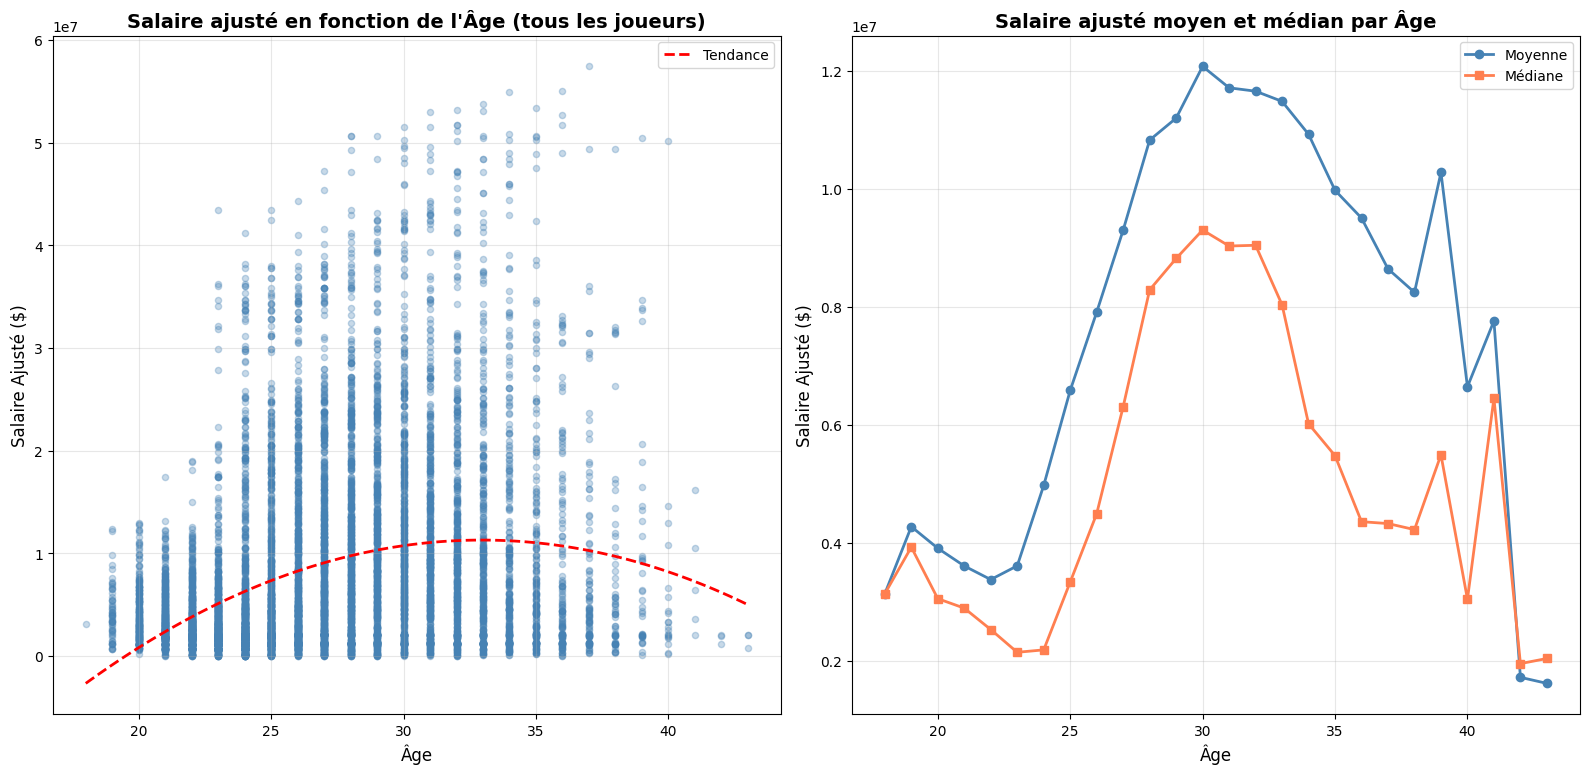

In [10]:
plot_desc_salary('AGE' , 'Âge')

On observe que les salaires moyens et médians sont maximaux à 30 ans. On pourrait s'attendre plutôt à atteindre ce pic un peu plus tôt dans la carrière d'un joueur, qui devrait commencer à décliner vers cet âge, cependant on a probablement un biais de sélection dans notre cas. En effet si un joueur est encore présent à 30 ans dans la ligue c'est certainement qu'il est performant, sinon il aurait déjà été congédié au cours des années précédentes. Ainsi, puisqu'il reste les excellent joueurs, extrêmement payés, les salaires sont tirés vers le haut. L'augmentation de la différence entre salaire moyen et médian passé 30 ans (Graph. 2) confirme ce point de vue. 

La variance forte des salaires pour les plus vieux joueurs (passé 35 ans) s'explique par la présence de 2 profils : les meilleurs joueurs qui continuent et sont grassement payés, et les vétérans payés faiblement pour donner des conseils aux jeunes plutôt que pour vraiment beaucoup jouer.  

D'autre par les salaires plus élevés pour les très jeunes (18-19ans) que pour les jeunes (~22ans), traduit d'un autre biais de sélection, en effet les seuls joueurs aussi jeunes à se présenter à la Draft (Choix des nouveaux joueurs dans la ligue) et à être sélectionnés sont souvent des talents générationnels qui ne passent pas ou peu par l'université (par exemple, LeBron James, Kobe Bryant ou plus récemment Victor Wembanyama et Cooper Flag).  

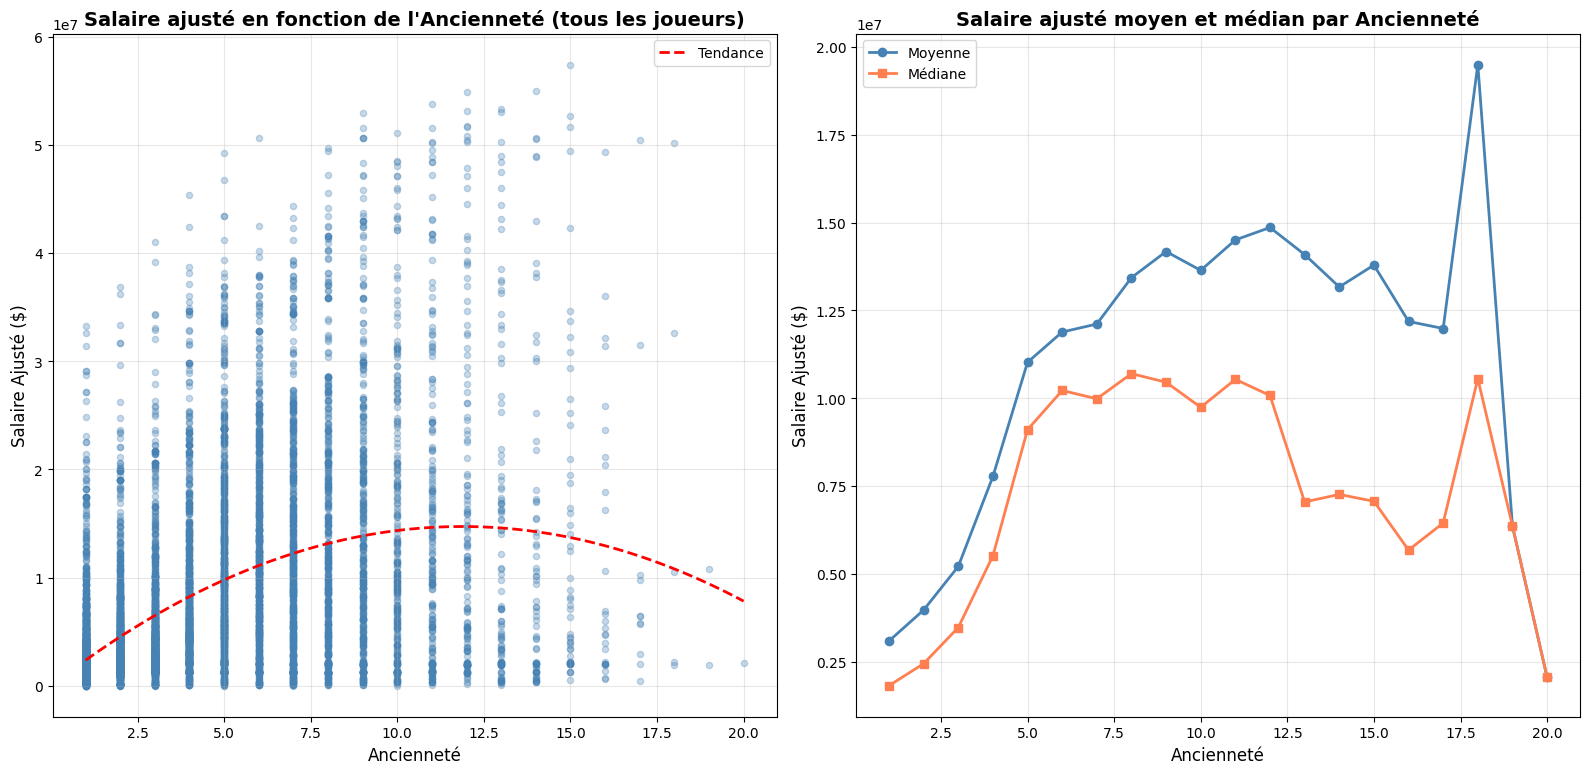

In [11]:
plot_desc_salary('YOE' , 'Ancienneté')

Pour ne tenir compte que de l'expérience, sans différencier l'age d'arrivée dans la ligue, on utilise la variable YOE (nombre d'années dans la ligue) qui indique l'ancienneté. On trouve des représentations similaires aux graphiques précédents, sans le problème concernant les plus jeunes.

### Salaire par poste occupé

La valeur des joueurs varie-t-elle de manière importante selon la position à laquelle ils évoluent ?  
Pour faire le parallèle avec d'autres sport, ils sembleraient que ce soit le cas au football ou au rugby. Les buteurs au football, peut-être car inscrire des buts est plus souvent mis en avant que défendre, et les demi-d'ouverture (10) peut-être car il occupe un poste très différents des autres, sont en moyennes mieux payés que les autres. Mais est-ce aussi le cas en NBA, où tous les joueurs jouent des 2 cotés du terrain? 

c:\Users\lunat\OneDrive\Desktop\NBA_stats\src\plot_func.py:381: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_with_salary, y='Position', x='adjusted_salary', order=positions_order, palette='Set2')


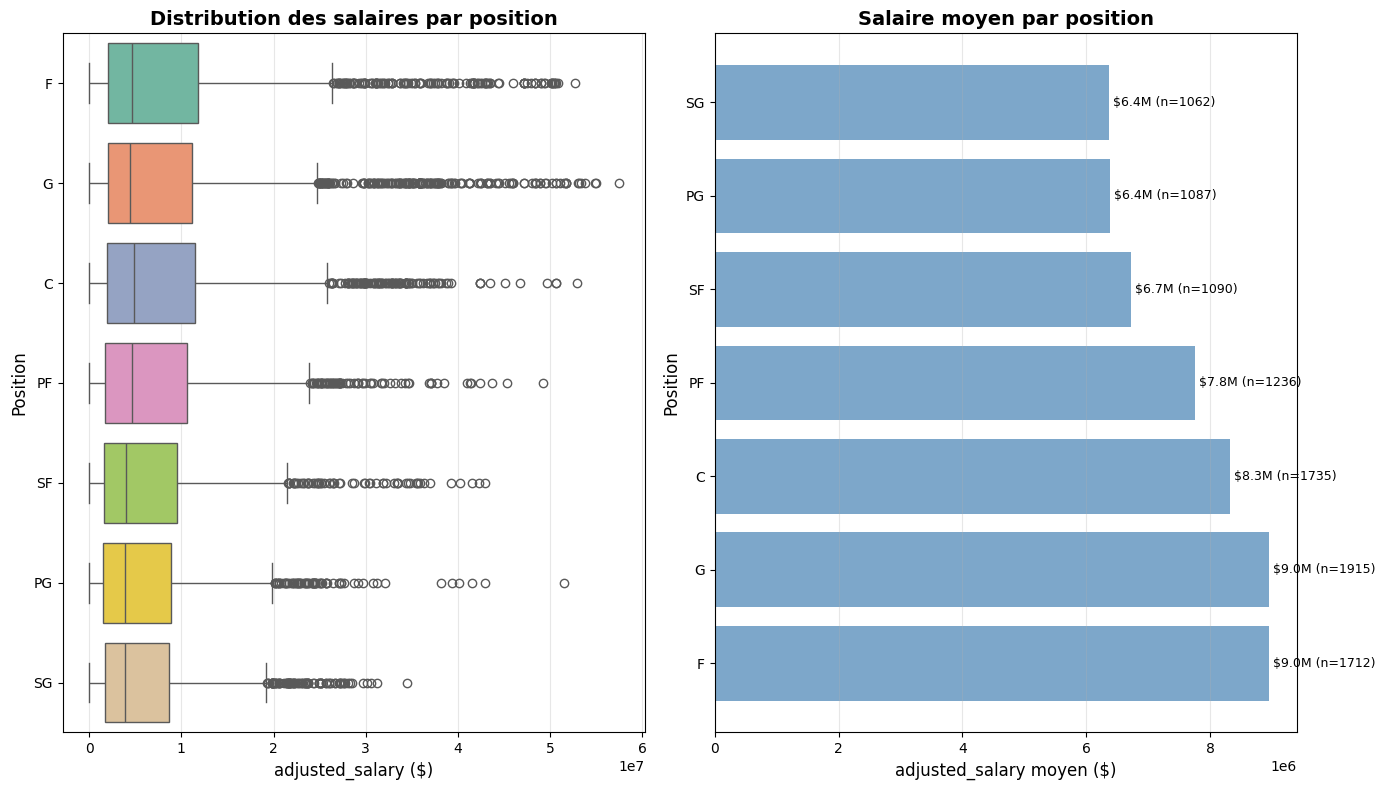


Résumé des salaires par position:
Position  mean_millions  median_millions  count
       F       8.956503         4.653500   1712
       G       8.955001         4.441875   1915
       C       8.324029         4.889491   1735
      PF       7.753565         4.674158   1236
      SF       6.718391         4.028245   1090
      PG       6.388404         3.883604   1087
      SG       6.375257         3.884400   1062


In [12]:
from src.plot_func import plot_salary_by_position

plot_salary_by_position(df)

PG = Meneur , SG = Arrière , G = Meneur et Arrière  
SF = Ailier , PF = Ailier Fort , F = Ailier et Ailier Fort  
C = Pivot

Il ne semble pas y avoir de différences une fois que l'on regroupe (PG, SG, G) et (SF, PF, F).
Cependant les joueurs dont la position est F ou G, sont mieux payés en moyenne, cela s'explique par leur polyvalence, ils peuvent occuper deux postes différents à un niveau très élevé. Cela concerne généralement les très bons joueurs qui sont très bien payés, les joueurs moins performants ont déjà peu de temps de jeu sur un poste unique. On ne les voient donc pas vraiment évolué dans une autre position, ainsi ils ne sont pas catégorisé comme F ou G. 

### Salaire par franchise

Certaines franchises payent mieux que d'autres ?  
On peut imaginer que certaines franchises disposent de moyens financier plus important que d'autres, notamment les équipes des "grands marchés" (les grandes zones métropolitaines américaines) comme Los Angeles, New York ou Philadelphie par exemple. En effet elles peuvent vendre le produit que représente le basket-ball à un plus grand nombre, elles ont donc intéret à attirer les meilleurs joueurs et être compétitifs pour vendre plus cher les billets au stade et le merchandising, etc...  
La mise en place de "Salary Cap" (Masse salariale à ne pas dépasser) depuis 1984, ou de "Luxury Tax" (Taxes très lourdes en cas de dépassement de certains paliers du salary cap), tentent de lutter contre la différence d'attraction des équipes. Mais restent ils tout de même des différences de moyen important? 

) missing from font(s) DejaVu Sans._stats\src\plot_func.py:450: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.on\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


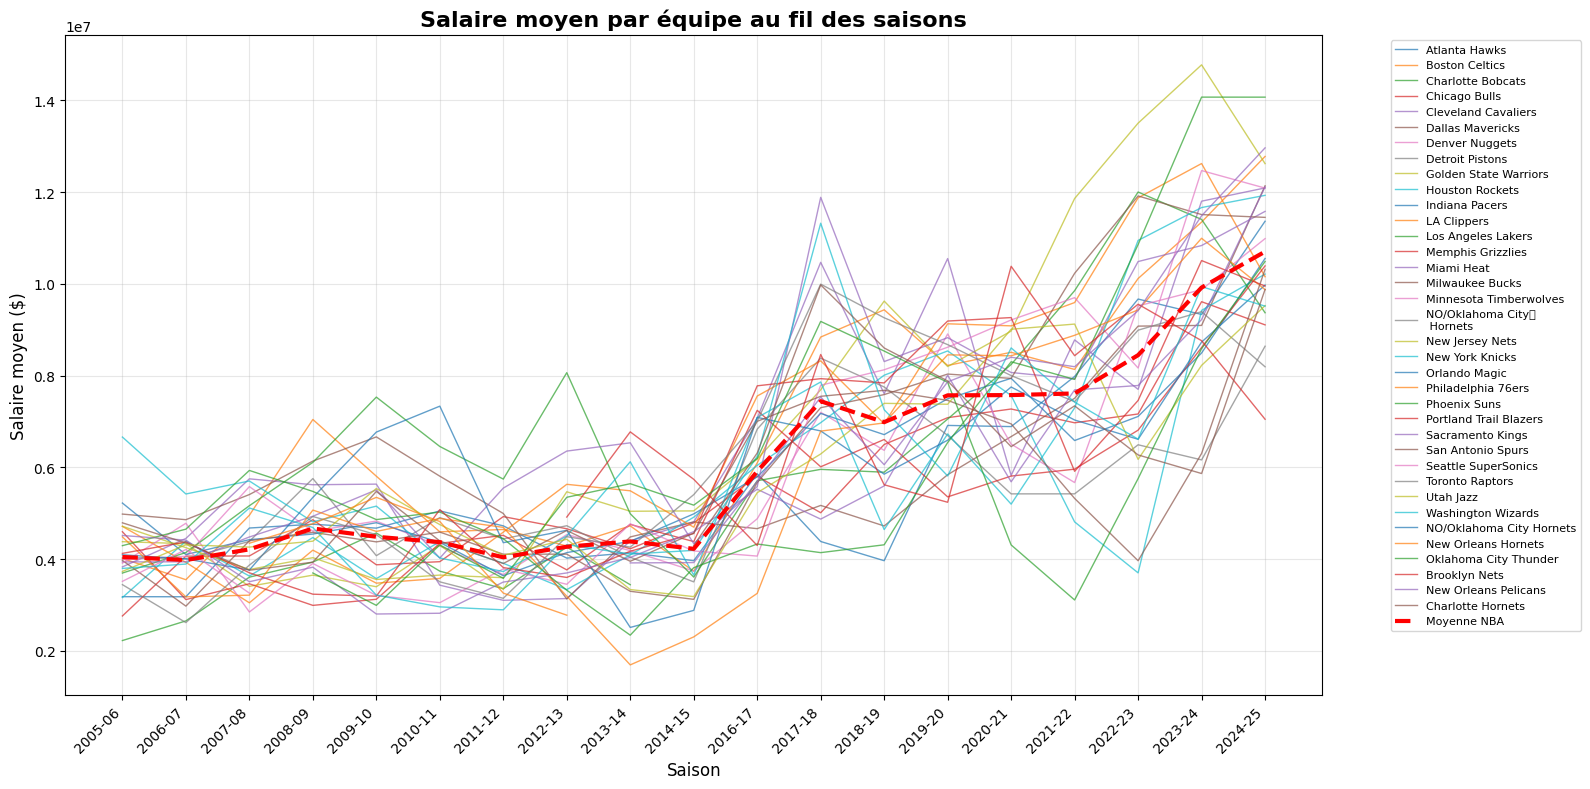

In [13]:
from src.plot_func import plot_salary_by_team_over_time

plot_salary_by_team_over_time(df, season_start='2005-06')

Il ne semble pas qu'une équipe reste tout au long de la période parmi les équipes avec le salaire moyen le plus élevé. Sur plusieurs années, cela est possible comme pour les Phoenix Suns depuis le début de la décennie 2020, mais ces derniers n'étaient pas parmi les plus gros offreurs une dizaine d'années auparavant. Cela s'explique par des cycles d'arrivées et de départs de joueurs stars. Dans le cas de Phoenix, ils disposent ces dernières années d'un des meilleurs joueurs offensifs de la ligue en la personne de Devin Booker. Il est alors fortement payé, et les ambitions de la franchise ont été revues à la hausse depuis son arrivée. En conséquence, elle investit sur d'autres joueurs très forts et donc très chers, dans l'objectif de gagner un titre. Cependant cela s'accompagne de taxes très importantes pour avoir enfreint les règles de fair-play financier, et donc, ce n'est pas soutenable à long terme.

Maintenant que nous avons une meilleure compréhension de nos données et quelques idées des tendances et des facteurs d'influence du salaire en tête, nettoyons notre base de données en vue d'élaborer des modèles robustes.

---

# 3 - Nettoyage et pre-processing de la BDD

Grâce au scraping mis en place, on récupère un jeu de données assez conséquant (10k+ données et presque 80 colonnes). Afin de réduire le volume de données à traîter pour accélérer le temps de calcul des modèles sans perdre trop d'information, on peut commencer par supprimer les données très corrélées (>= à 80% en valeur absolue). Commençons d'abord par calculer le nombre de paires de variables qui sont largement corrélées :

In [14]:
from src.clean_dataset_fun import analyze_correlations

# Analyse des corrélations élevées (>= 80%)

correlations_list = analyze_correlations(df, threshold=0.80, verbose=True)

Variables avec une corrélation >= 80% (en valeur absolue):

Nombre total de paires trouvées: 182

  1. NBA_FANTASY_PTS_RANK <-> WNBA_FANTASY_PTS_RANK : +0.9957
  2. WNBA_FANTASY_PTS     <-> NBA_FANTASY_PTS      : +0.9949
  3. PTS_RANK             <-> FGM_RANK             : +0.9925
  4. PTS                  <-> FGM                  : +0.9896
  5. FG3A                 <-> FG3M                 : +0.9858
  6. FGA_RANK             <-> PTS_RANK             : +0.9834
  7. MIN                  <-> MIN_RANK             : -0.9830
  8. FTM                  <-> FTA                  : +0.9825
  9. PTS                  <-> FGA                  : +0.9821
 10. FTM_RANK             <-> FTA_RANK             : +0.9821
 11. W_RANK               <-> W                    : -0.9816
 12. FGM                  <-> FGA                  : +0.9794
 13. FGA_RANK             <-> FGM_RANK             : +0.9781
 14. adjusted_salary      <-> Salary               : +0.9775
 15. FG3A_RANK            <-> FG3M_RANK        

On remarque qu'il y a 172 paires de variables qui sont extrêmement corrélées. On va donc supprimer une partie de ces variables qui portent vraissemblablement la même information que les autres. 
On conserve également toutes les métriques de perforomance des joueurs sur le terrain, car on veut mesurer l'impact de la performance sur le terrain des joueurs sur l'évolution de leur salaire.

In [15]:
from src.clean_dataset_fun import remove_highly_correlated_features

# Liste des variables de performance à protéger lors de la suppression des colonnes corrélées, 
# car on veut mesurer l'impact de la performance sur le terrain des joueurs sur l'évolution de leur salaire
# On ne garde pas forcement les Fantasy Points, car bien que corrélés à la performance, elles ne permettent 
# pas de différencier les types de performance (scoring, rebonds, passes, etc.)
performance_vars = [

    # Temps de jeu et résultats d'équipe
    "GP", "W", "L", "W_PCT", "MIN", 
    
    # Scoring et efficacité au tir
    "PTS", "FGM", "FGA"
    "FG3M", "FG3A"
    "FTM", "FTA"
    
    # Activité sur le terrain (Rebonds, Passes, etc.)
    "OREB", "DREB", "REB", "AST", "TOV", "STL", "BLK", "BLKA",
    
    # Fautes et impact
    "PF", "PFD", "PLUS_MINUS", 
    
    # Accomplissements
    "DD2", "TD3"
]

# On protège aussi les colonnes de salaire car ce sont nos variables cibles
protected_columns = ['Salary', 'adjusted_salary', 'next_adjusted_salary']

columns_to_drop = remove_highly_correlated_features(df, threshold=0.80, protected_cols=protected_columns+performance_vars, verbose=False)

df_cleaned = df.drop(columns=columns_to_drop)

print(f"Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")

print(f"Dataset nettoyé: {len(df_cleaned)} lignes, {len(df_cleaned.columns)} colonnes")

Dataset chargé: 9846 lignes, 79 colonnes
Dataset nettoyé: 9846 lignes, 45 colonnes


En procédant de cette manière, on arrive à diviser le nombre de variables par 2, ce qui va considérablement améliorer la performance du code. Maintenant, concentrons nous sur la suppression des outliers de cette nouvelle base de données. En effet, il y a certaines données qui vont compromettre la qualité de nos modèles car elles sont associées à des cas très particuliers. Par exemple, on va supprimer les informations sur les joueurs dont le salaire ajusté à l'inflation est inférieur 500k$, car c'était le salaire minimum en NBA en 2000. Les joueurs gagnant un montant inférieur ne jouent pas en NBA de manière régulière ou à plein temps, on supprime donc les points associés. De plus, il arrive qu'un joueur voit son salaire drastiquement diminuer car il arrive en fin de carrière, or nous nous intéressons plutôt à l'augmentation ou la baisse des salaires des joueurs actifs, en fonction de leur qualité de jeu. On supprime donc les points associés à une baisse considérable de salaire qui indique généralement une fin de carrière (ainsi que les points suivants car un joueur peut jouer quelques saisons avec un salaire de fin de carrière).

In [16]:
from src.clean_dataset_fun import clean_outliers

df_clean = clean_outliers(df_cleaned, min_salary=500000, drop_threshold=-0.70)

NETTOYAGE DES OUTLIERS

Dataset initial: 9846 lignes

1. Suppression des salaires ajustés < 500,000$
   Lignes supprimées: 375
   Lignes restantes: 9471

2. Détection des fins de carrière (baisse > 70%)
   Joueurs avec baisse > 70%: 336
   Lignes identifiées (fin de carrière): 748
   Lignes supprimées (fin de carrière): 748
   Lignes restantes: 8723

RÉSUMÉ DU NETTOYAGE
Dataset initial:                9846 lignes
Supprimés (salaire < 500,000$):    375 lignes
Supprimés (fin de carrière):    748 lignes
Total supprimé:                 1123 lignes (11.41%)
Dataset final:                  8723 lignes

 Nettoyage des outliers terminé


De cette manière, on supprime plus de 1000 données qui vont contribuer à dégrader la qualité de nos modèles. Maintenant que nous avons supprimé les variables et points de mauvaise qualité, on va appliqué un pre-processing du dataset en plusieurs étapes : 

1. Suppression des colonnes inutiles pour les modèles ('PLAYER_ID', 'PLAYER_NAME'...)
2. Encodage des variables catégorielles (comme la position des joueurs, ID de l'équipe)
3. Normalisation des variables numériques
4. Vérification des valeurs manquantes (on supprime les données qui n'ont pas de 'next_adjusted_salary', car c'est la variable target de nos modèles. Sinon on remplace par la valeur moyenne)

In [17]:
from src.clean_dataset_fun import preprocess_pipeline

df_preprocessed, artifacts = preprocess_pipeline(df_clean, verbose=True)

print(f"Dataset preprocessed: {len(df_preprocessed)} lignes, {len(df_preprocessed.columns)} colonnes")

PIPELINE DE PRÉTRAITEMENT DES DONNÉES

1. Dataset initial: (8723, 45)

2. Colonnes supprimées: ['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'Team', 'Season', 'Year', 'Salary', 'Rank']
Nouvelles dimensions: (8723, 36)

3. Encodage des variables catégorielles:

Position encodée:
   Nombre de classes: 9
   Classes: ['C', 'F', 'G', 'GF', 'PF', 'PG', 'SF', 'SG', 'nan']
   Mapping: {'C': np.int64(0), 'F': np.int64(1), 'G': np.int64(2), 'GF': np.int64(3), 'PF': np.int64(4), 'PG': np.int64(5), 'SF': np.int64(6), 'SG': np.int64(7), 'nan': np.int64(8)}

TEAM_ABBREVIATION encodée:
   Nombre de classes: 36

Colonnes catégorielles originales supprimées: ['Position', 'TEAM_ABBREVIATION']

4. Colonnes à normaliser (35):
   ['AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FG_PCT', 'FG3M', 'FG3_PCT']...

Normalisation effectuée avec StandardScaler
   Moyenne ≈ 0, Écart-type ≈ 1

5. Valeurs manquantes détectées:
   next_adjusted_salary: 1436 (16.46%)
   Changed_team: 1436 (16.46%)

Lignes supprimé

---


# 4 - Modélisation

---

## 4.1 Régressions

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

from src.plot_func import plot_rls, plot_error, plot_lowess, plot_rlm

### 4.1.1 Régressions linéaires simples

Considérons les 4 modèles possibles en régression linéaire simple : Niveau-Niveau , Log-Niveau, Niveau-Log et Log-Log.  
On utilise la base pré-normalisation (mais nettoyée) pour la régression linéaire simple. 

In [19]:
print(f"Nombre de joueurs à 0 pts : {(df_clean['PTS']==0).sum()}")
print(f"Nombre de joueurs avec un salaire nul : {(df_clean['adjusted_salary']==0).sum()}")

Nombre de joueurs à 0 pts : 29
Nombre de joueurs avec un salaire nul : 0


On peut donc envisager un passage au logarithme pour des représentations en Log - Niveau, par exemple, car on ne perd pas trop de données en supprimant les valeurs nulles (seulement 45 suppressions concernant les joueurs n'ayant marqué aucun point).. Et voir si cet représentation est meilleure que le Niveau-Niveau classique pour une regéssion sur les points inscrits, par exemple. 

In [20]:
df_log = df_clean[(df_clean['PTS'] > 0) & (df_clean['adjusted_salary'] > 0)].copy()
df_log['log_PTS'] = np.log(df_log['PTS'])
df_log['log_salary'] = np.log(df_log['adjusted_salary'])

# Regression    Niveau - Niveau
reg_pts = smf.ols('adjusted_salary ~ PTS', data=df_log).fit()
df_log['salary_predicted_pts'] = reg_pts.predict(df_log['PTS'])    # Salaire prédit par le modèle   Niveau - Niveau

# Regression    Niveau - Log
reg_pts_niv_log = smf.ols('adjusted_salary ~ log_PTS', data=df_log).fit()
df_log['salary_predicted_pts_niv_log'] = reg_pts_niv_log.predict(df_log['log_PTS'])  # Salaire prédit par le modèle   Niveau - Log

# Regression    Log - Niveau
reg_pts_log_niv = smf.ols('log_salary ~ PTS', data=df_log).fit()
df_log['log_salary_predicted_pts'] = reg_pts_log_niv.predict(df_log['PTS'])
df_log['salary_predicted_pts_log_niv'] = np.exp(df_log['log_salary_predicted_pts']) # Salaire prédit par le modèle   Log - Niveau

# Regression    Log - Log
reg_pts_log_log = smf.ols('log_salary ~ log_PTS', data=df_log).fit()
df_log['log_salary_predicted_log_pts'] = reg_pts_log_log.predict(df_log['log_PTS'])
df_log['salary_predicted_pts_log_log'] = np.exp(df_log['log_salary_predicted_log_pts'])  # Salaire prédit par le modèle   Log - log

In [21]:
# Comparaison du R^2 des différents modèles

tab_R2 = pd.DataFrame({
    'Modèle': ['Niveau–Niveau', 'Niveau–Log', 'Log–Niveau', 'Log–Log'],
    'R2': [ reg_pts.rsquared , reg_pts_niv_log.rsquared , reg_pts_log_niv.rsquared, reg_pts_log_log.rsquared]
})
tab_R2['R2'] = tab_R2['R2'].round(3)
tab_R2_styled = (
    tab_R2.style
    .highlight_max(subset=['R2'], color='lightgreen')
    .format({'R2': '{:.3f}'}) 
)

display(tab_R2_styled)

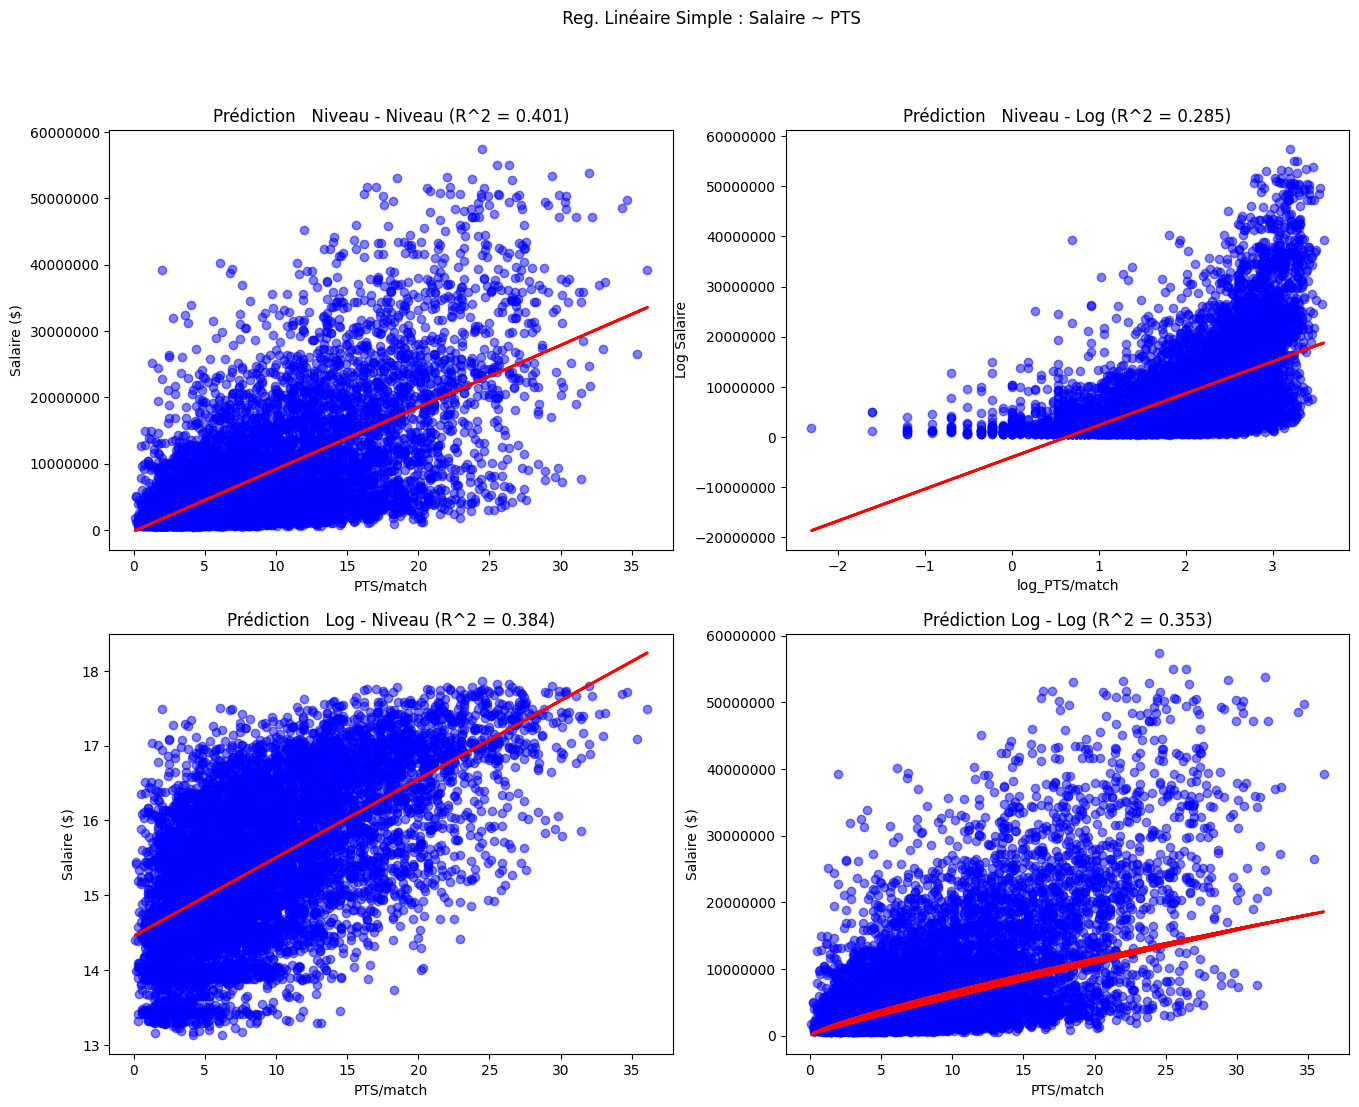

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.suptitle(f" Reg. Linéaire Simple : Salaire ~ PTS")

# Regression    Niveau - Niveau
plot_rls('PTS','salary_predicted_pts', reg_pts, axes[0,0], data = df_log)
axes[0,0].set_title(f'Prédiction   Niveau - Niveau (R^2 = {reg_pts.rsquared:.3f})')

# Regression    Niveau - Log
plot_rls('log_PTS','salary_predicted_pts_niv_log', reg_pts_niv_log, axes[0,1], data = df_log)
axes[0,1].set_title(f'Prédiction   Niveau - Log (R^2 = { reg_pts_niv_log.rsquared:.3f})')
axes[0,1].set_ylabel('Log Salaire')

# Regression    Log - Niveau
plot_rls('PTS','log_salary_predicted_pts', reg_pts_log_niv, axes[1,0], y = 'log_salary', data = df_log)
axes[1,0].set_title(f'Prédiction   Log - Niveau (R^2 = {reg_pts_log_niv.rsquared:.3f})')

# Regression    Log - Log
plot_rls('PTS','salary_predicted_pts_log_log', reg_pts_log_log, axes[1,1], data = df_log)
axes[1,1].set_title(f'Prédiction Log - Log (R^2 = {reg_pts_log_log.rsquared:.3f})')

plt.show()

Que ce soit via les R2 ou par observasition graphique, on voit que le modèle avec la meilleure qualité de prédiction reste le plus simple : le modèle Niveau - Niveau (Salaire ~ PTS).

In [23]:
# Regression Niveau - Niveau (Salaire ~ PTS)
reg_pts = smf.ols('adjusted_salary ~ PTS', data=df_clean).fit()
df_clean['salary_predicted_pts'] = reg_pts.predict(df_clean[['PTS']])

# Regression Niveau - Niveau (Salaire ~ PLUS_MINUS)
reg_plus_minus = smf.ols('adjusted_salary ~ PLUS_MINUS', data=df_clean).fit()
df_clean['salary_predicted_plus_minus'] = reg_plus_minus.predict(df_clean[['PLUS_MINUS']])


Statistiques des erreurs (Salaire ~ PTS) :
   Erreur moyenne : 0
   Écart-type des erreurs : 7,156,107

Statistiques des erreurs (Salaire ~ (+/-)) :
   Erreur moyenne : 0
   Écart-type des erreurs : 8,848,889


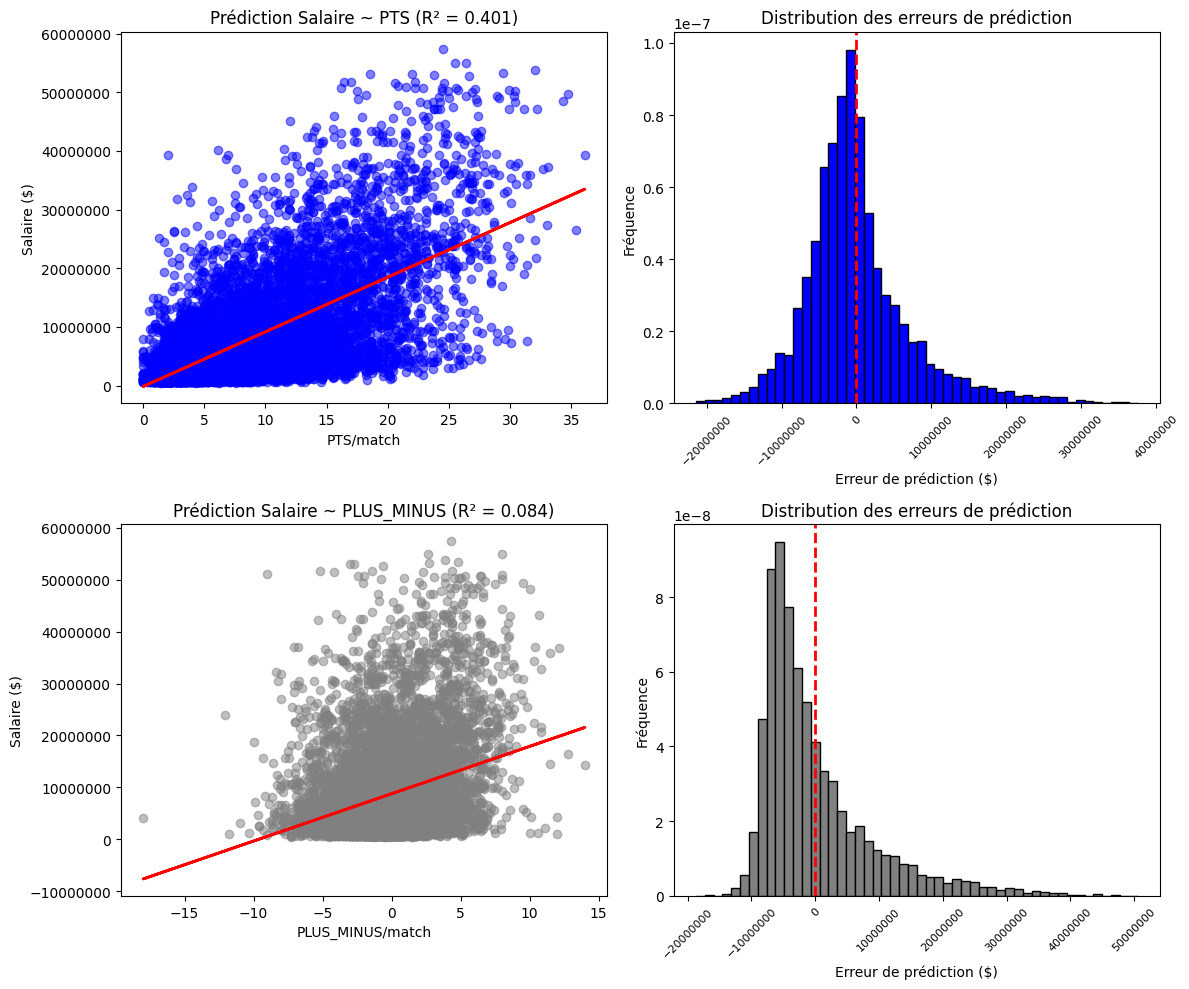

In [24]:
# Visualiser les prédictions vs valeurs réelles
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Regression linéaire simple du Salaire ~ PTS
plot_rls('PTS','salary_predicted_pts', reg_pts, axes[0,0], data = df_clean)

# Distribution des erreurs
plot_error('salary_predicted_pts',axes[0,1] , nom_reg = "Salaire ~ PTS", data = df_clean)


# Regression linéaire simple du Salaire ~ (+/-)
plot_rls('PLUS_MINUS', 'salary_predicted_plus_minus', reg_plus_minus, axes[1,0], color = 'grey', data = df_clean)

# Distribution des erreurs
plot_error('salary_predicted_plus_minus', axes[1,1], color ='grey', nom_reg = "Salaire ~ (+/-)", data = df_clean)

plt.tight_layout()
plt.show()

Pour estimer le salaire des joueurs, la première composante que l'on pense à étudier est le nombre de points inscrits par match. Dans un premier temps, on étudie la régression linéaire simple du salaire sur la moyenne de points inscrits par match ( Salaire ~ PTS ), pour obtenir une première prédiction simple du salaire.  
  
Mais on peut aussi considérer d'autres statistiques qui illustrent mieux les apports globaux d'un joueur sur le terrain et pas uniquement sa capacité à marquer.
Le Plus-Minus est une statistique qui mesure l'impact d'un joueur sur un match en comparant les points marqués et encaissés par son équipe lorsqu'il est sur le terrain. Cela permet donc d'observer dans une certaine mesure le poids d'un joueur individuellement, non seulement en attaque (Nombre de points marqués) mais aussi en défense (Nombre de points encaissés), il tient aussi compte de la dimension collective de l'équipe et donc de l'importance du joueur en question dans le bon fonctionnement de celle-ci.
On remarque cependant que la régression linéaire simple avec cette mesure de performance présente certains problème, notamment:  

- Un salaire prédit négatif pour les joueurs avec un +/- mauvais (Hors les joueurs ne payent pas pour jouer en NBA) 
- Une dispersion du nuage de points importante, pour une même performance selon l'indicateur +/- le salaire (réel) peut énormément varier ( cela peut s'expliquer par les énormes salaires des joueurs stars des équipes en difficulté, en effet si l'equipe perd souvent le +/- des joueurs de l'équipe est rarement bon et il en va de même pour le joueur star)   
- Un R^2 faible (le +/- explique une faible portion du salaire)

De manière générale, les régressions linéaires simples seront insuffisantes pour prédire précisement les salaires.

#### Significativité pratique vs. statistique (Points , +/-)
On a vu que 'PTS' et '+/-' semble avoir un effet (pratique) sur les salaires, mais sont-ils vraiment significatifs statistiquement.  
On va utiliser un test de Student pour le vérifier. 

H0 : " Le nombre de points inscrits en moyenne n'a pas d'effet significatif sur les salaires "   vs.    H1 :" L'effet de 'PTS' sur les salaires est significatif "  

Avec un modèle de régression linéaire simple (Niveau - Niveau) : Salaires = B0 + B1 * PTS + e  
cela revient à tester     H0: " B1=0 "   vs.   H1: "B1 !=0 "  

In [25]:
print(f"Coef de 'PTS' :  {round(reg_pts.params['PTS'],0)}")         # Significativité pratique de 'PTS' 
print(f"P-valeur de 'PTS' :  {round(reg_pts.pvalues['PTS'],3)}")    # Significativité statistique de 'PTS'

Coef de 'PTS' :  931982.0
P-valeur de 'PTS' :  0.0


On a p-valeur < 0.01, c'est à dire que l'on rejette l'hypothèse H0 au seuil de 1%, donc l'effet du nombre de points inscrits en moyenne  sur le salaire, est statistiquement significatif au seuil de 1%. 
La p-valeur est même approximativement nulle, donc la variable est significative à un seuil extrèmement faible.

In [26]:
print(f"Coef de '+/-' :  {round(reg_plus_minus.params['PLUS_MINUS'],0)}")        # Significativité pratique de 'PLUS_MINUS'
print(f"P-valeur de '+/-' :  {round(reg_plus_minus.pvalues['PLUS_MINUS'],3)}")   # Significativité statistique de 'PLUS_MINUS'

Coef de '+/-' :  912568.0
P-valeur de '+/-' :  0.0


On a p-valeur < 0.01, c'est à dire que l'on rejette l'hypothèse H0 au seuil de 1%, donc l'effet du (+/-) sur le salaire, est statistiquement significatif au seuil de 1%. 

**Conclusion** : Les variables 'PTS' et '+/-' ont un effet statistiquement significatif au seuil de 1% sur 'adjusted_salary' dans les modèles de régression linéaire simple étudiés.  
En pratique, chacune à un effet très fort sur les salaires.   
Une variation de 1 point inscrits en moyenne correspond à une variation de 930 000 USD dans le salaire.   
Une variation de 1 du '+/-' correspond à une variation de 910 000 USD dans le salaire. 

### 4.1.2 Régression locale simple (LOWESS)
##### Peut on trouver une régression avec une courbe de tendance plus proche du nuage de points ? 
Plutôt que d’utiliser la méthode des MCO on va utiliser la méthode lowess (locally weighted scatterplot smoothing) qui agrège plusieurs estimations locales tenant compte des valeurs voisines en une estimation globale. 
Cela permet d’obtenir une courbe qui modélisent mieux les valeurs extrêmes et tient plus compte des fluctuations locales des salaires. On peut notamment voir si l'elstacité entre salaire et 'PTS' ou '+/-' n'est pas constante.


Statistiques des erreurs (Salaire ~ PTS (MCO)) :
   Erreur moyenne : 0
   Écart-type des erreurs : 7,156,107

Statistiques des erreurs (Salaire ~ PTS (LOWESS)) :
   Erreur moyenne : 1,344,299
   Écart-type des erreurs : 7,130,313


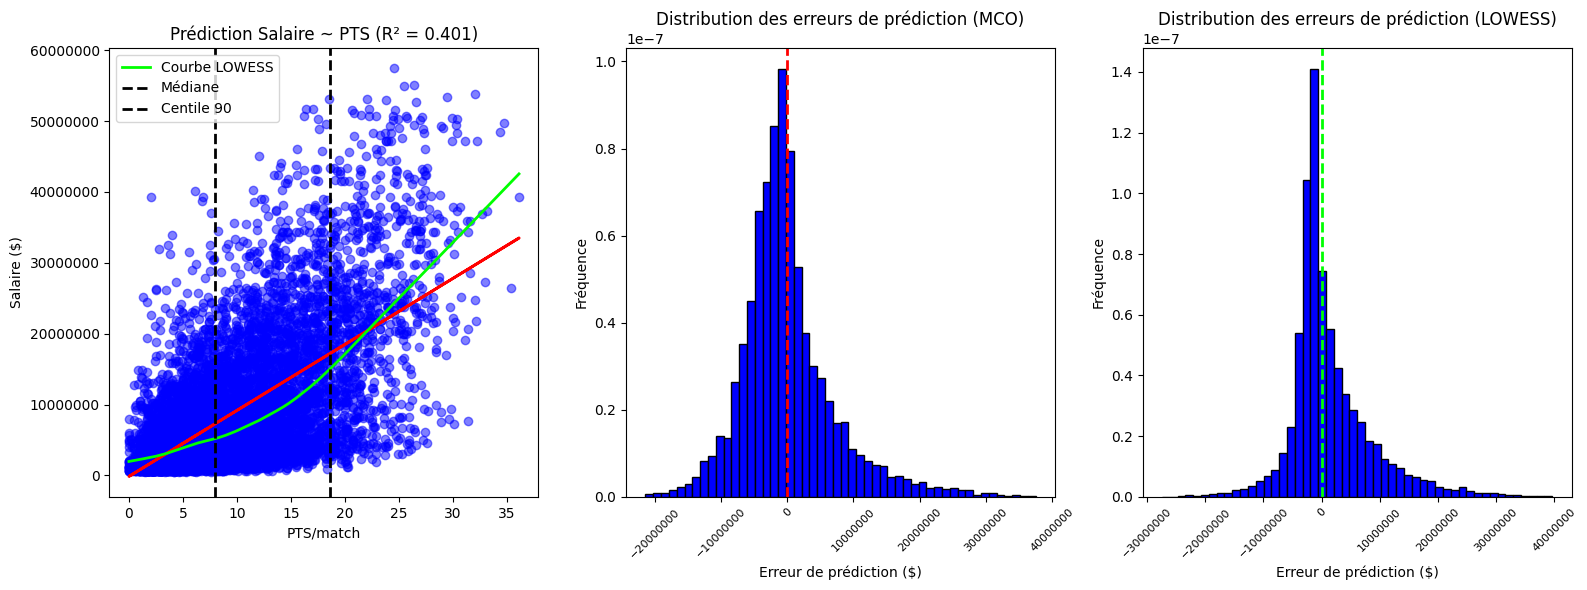

In [27]:
plot_lowess('PTS', 'salary_predicted_pts', reg_pts, y='adjusted_salary', color='blue', data=df_clean)

On observe bien que l'élasticité du salaire par rapport aux 'PTS' ou '+/-' n'est pas constante dans les 2 modèles d'estimation avec LOWESS. 
Le salaire prédit par le modèle LOWESS, est presque constant pour les joueurs ayant un '+/-' négatif ou nul, et qu'il explose pour les joueurs pour lequels il est fortement positif. En pratique les joueurs avec un '+/-' positif sont les bons ou très bon joueurs qui sont donc grassement payés. A l'inverse,t un '+/-' négatif signifie qu'ils font en moyenne 'perdre' l'équipe et leur valeur diminue en conséquence.  
  
Pour le modèle Salaire ~ PTS, avec LOWESS, on remarque que la courbe de tendance est convexe, l'effet marginal d'un point supplémentaire sur le salaire est beaucoup plus élevé lorsque l'on inscrit en moyenne plus de 20 points par match que lorsque l'on en inscrit moins de 5. Il est en effet beaucoup plus difficile d'augmenter son apport offensif lorsqu'il est déjà élevé car le temps de jeu est limité à 48 minutes par match. Seuls les meilleurs joueurs sont capables d'inscrire plus de 20 points par match, ce qui se reflète dans leur salaire.  

On peut par exemple définir arbitrairement 3 catégories de joueurs : les "bench players", les "role players" et les "franchise player".  
  
Les "bench players" sont souvent des joueurs remplacant qui ne possèdent que peu de temps de jeu et qui ne peuvent généralement pas inscrire une forte quantité de points. Dans notre cas, les "role players" sont des joueurs titulaires ou remplacants avec un temps de jeu conséquent et qui ont donc la possibilité d'inscrire plus de points que les "bench players" mais pas autant que les "franchise players", ils sont également mieux payés que les "role player". Les "franchise players" quant à eux sont des joueurs stars, ce sont généralement les leaders offensifs de leur équipe, ce qui leur permet d'inscire un nombre conséquent de paniers et donc de points. On compte généralement un "franchise player" par équipe (pour simplifier on considère que le top 10% des meilleurs scoreurs sont les "franchise player"), c'est aussi généralement sur lui que l'équipe investit le plus, ces joueurs ont la plupart du temps les salaires les plus élevés (exeption faite des rares franchise players très jeunes et encore sous contrat "rookie", un contrat à rémunération limitée).   
  
Sur le graphique 1, avant la première droite verticale (Mediane des points inscrits) on observe que les salaires prédits des "bench player" sont plutôt constants. On constate une augmentation des rémunérations pour les bons joueurs et enfin une explosion des salaires pour les meilleurs scoreurs, ceux qui inscrivent plus de 19 pts par match (soit plus que 90% des joueurs de la ligue).  


Statistiques des erreurs (Salaire ~ PLUS_MINUS (MCO)) :
   Erreur moyenne : 0
   Écart-type des erreurs : 8,848,889

Statistiques des erreurs (Salaire ~ PLUS_MINUS (LOWESS)) :
   Erreur moyenne : 2,369,414
   Écart-type des erreurs : 8,593,404


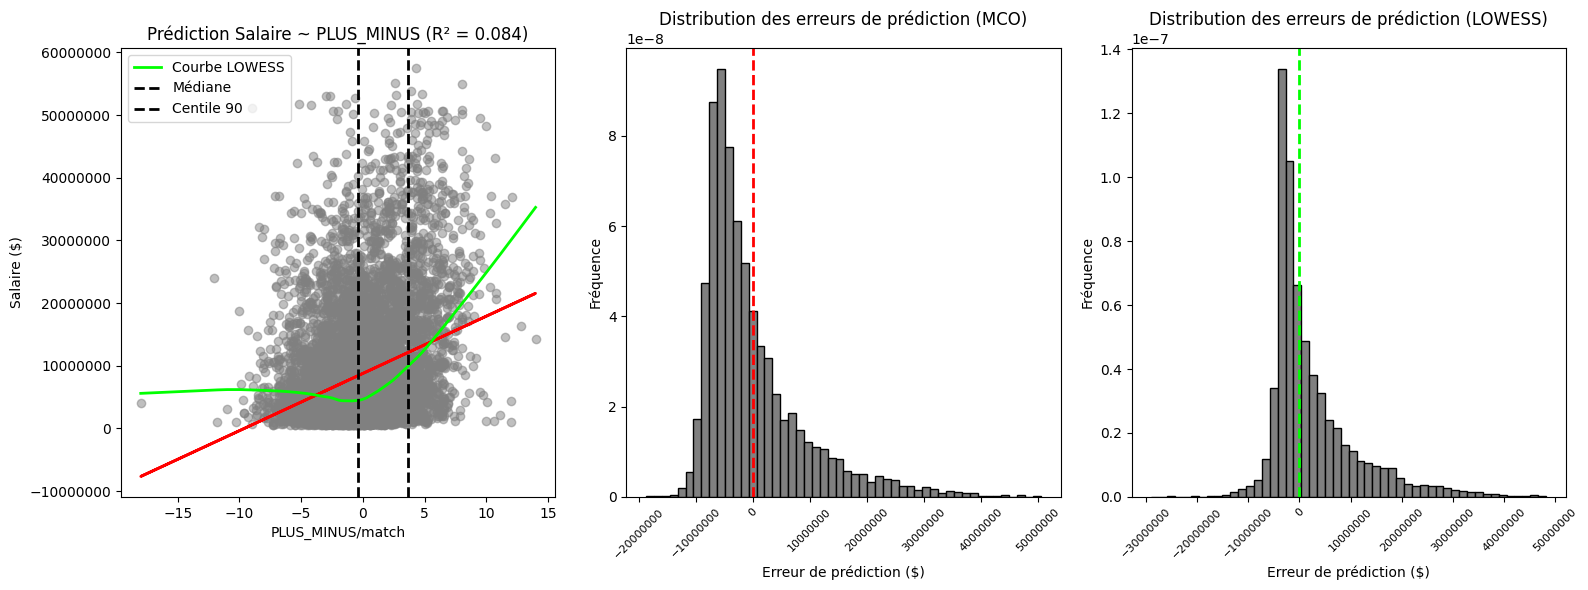

In [28]:
plot_lowess('PLUS_MINUS', 'salary_predicted_plus_minus', reg_plus_minus, y='adjusted_salary', color='grey', data=df_clean)

Les observations sont similaires pour la relation entre Salaire et (+/-). En se plaçant du point de vue des équipes, on peut distinguer trois catégories : les mauvais joueurs (<0 +/-), les bons joueurs (0 à 5) et les excellents joueurs (>5). On voit que les excellents joueurs qui font gagner leur équipe voit leur salaire exploser avec leur contribution à la victoire. L'effet est plus confus chez les joueurs qui font perdre leur équipe "mauvais joueurs" car cette catégorie regroupe des joueurs qui jouent peu et sont faiblement rémunérés, ainsi que les stars des équipes en difficultés qui restent fortement rémunérées. 

### 4.1.3 Régressions linéaires multiples
##### Les statistiques individuelles habituelles de jeu (PTS, REB, AST, STL, BLK) prédisent-elles les salaires des joueurs? 
On va désormais considérer une régression linéaire multiple qui tient compte des 5 principales statistiques ( PTS, REB, AST, STL, BLK ):  
          Salaire = B0 + B1xPTS + B2xREB + B3xAST + B4xSTL + B5xBLK + e

In [29]:
reg5 = smf.ols('adjusted_salary ~ PTS + REB + AST + STL + BLK', data=df_preprocessed).fit()
df_preprocessed['salary_predicted_5'] = reg5.predict(df_preprocessed[['PTS','REB','AST','STL','BLK']])

print(f"Erreur moyenne = {(reg5.resid.mean()).round(5)}") # On a un estimateur sans biais 

Erreur moyenne = 0.0


On souhaite savoir si les statistiques individuelles habituelles ont un impact sur le salaire, c'est à dire si au moins l'une d'elle permet d'expliquer le salaire, lorqu'on intègre les 5 au modèle.  
On cherche donc à faire un test de Fisher: 

H0 : " B1 = B2 = B3 = B4 = B5 = 0 "   vs    H1 : " (B1 != 0) ou (B2 != 0) ou (B3 != 0) ou (B4 != 0) ou (B5 != 0) "

In [30]:
print( "F-stat : ", round(reg5.fvalue))
print( "F-stat : ", reg5.f_pvalue)

F-stat :  1091
F-stat :  0.0


In [31]:
print(reg5.params)

Intercept   -0.030291
PTS          0.449395
REB          0.184085
AST          0.230829
STL         -0.146774
BLK          0.054354
dtype: float64


On observe que la  p-valeur de la statisique de Fisher est approximativement nulle, ce qui signifie que l'on rejette H0 à un seuil proche de 0.
Ainsi, ces 5 indicateurs ont un effet conjointement significatif sur le salaire.  
Ces 5 statistiques permettent donc de prédire en partie le salaire des joueurs.

Cependant on observe que l'effet d'une interception supplémentaire par match, toutes choses égales par ailleurs, est lié négativement au salaire dans notre modèle, ce qui semble incohérent. Une interception n'est pas une action négative au basket-ball, et a même un effet positif pour la victoire de son équipe. Il est donc étonnant qu'elle impacte négativement le salaire des joueurs. 
On peut toutefois supposer que les statistiques défensives, comme les interceptions ont moins d'effet sur le salaire que les points inscrits, en considérant la défense comme une "basse besogne" que les stars font moins l'effort de faire. Un profil plus défensif et moins productif en attaque serait, en moyenne, moins bien rémunéré. 


Statistiques des erreurs (Salaire ~ PTS + REB + AST + STL + BLK) :
   Erreur moyenne : 0
   Écart-type des erreurs : 1


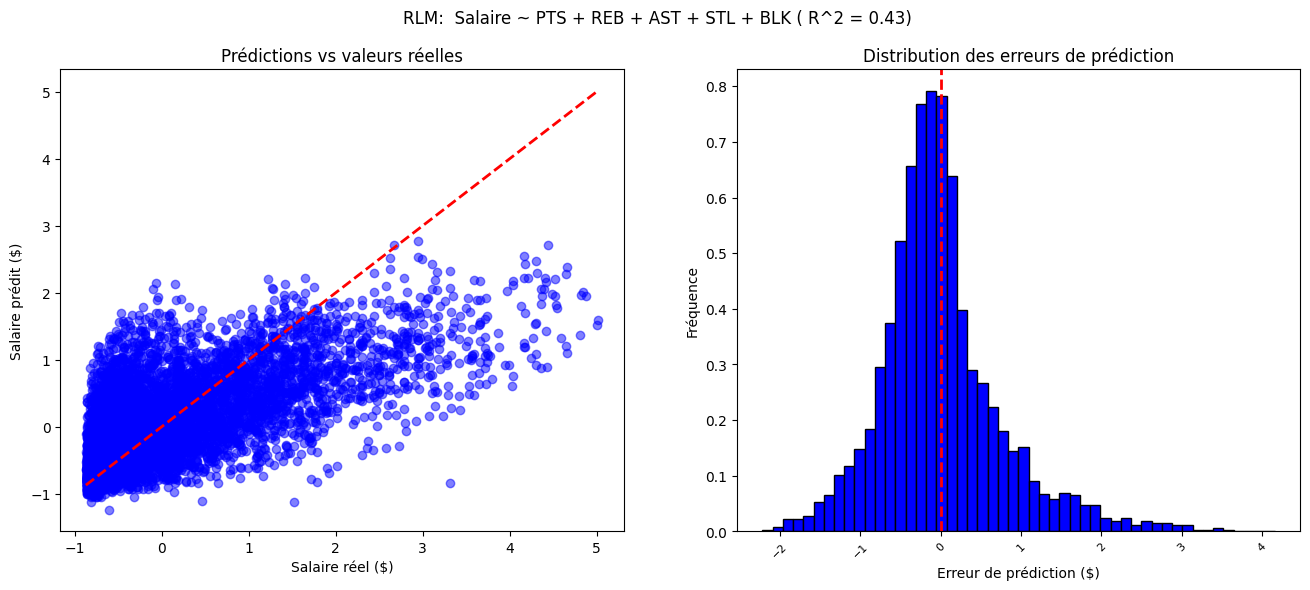

In [32]:
# Visualiser les prédictions vs valeurs réelles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle(f"RLM:  Salaire ~ PTS + REB + AST + STL + BLK ( R^2 = {reg5.rsquared_adj:.2f}) ")

# Graphique 1: Qualité de la RLM
plot_rlm('salary_predicted_5', axes[0], data = df_preprocessed)

# Graphique 2: Distribution des erreurs
plot_error('salary_predicted_5',axes[1] , nom_reg = "Salaire ~ PTS + REB + AST + STL + BLK", data = df_preprocessed)

En prenant en compte les statistiques majeures autres que les points, on obtient un R^2 ajusté de 0.43, soit une hausse de 0.03 du R^2 par rapport à la régression simple (Salaire ~ Points), il y a donc réel gain de qualité à ajouter ces variables, même si celui ci n'est pas aussi élevé qu'attendu.  
On peut néanmoins expliquer 43% de la variance des salaires des joueurs uniquement en tenant compte des statistiques individuelles majeures. Cela est important, car de nombreux autres facteurs pouvant avoir un fort impact sur les salaires ne sont pas pris en compte, tels que la réussite collective (% de victoires ) ou les distinctions individuelles (MVP, DPOY, etc.) concernant la performance seule. Mais l'age, l'expérience ou la popularité peuvent également en expliquer une partie significative. 

On a toujours du mal à prédire correctement les salaires les plus élevés, ce qui n'est pas étonnant car les joueurs concernés sont des superstars qui sont souvent expérimentés, générant des revenus important par la vente de maillots, de tickets pour les matchs, etc. 

Un paramètre dont nous n'avons pas encore tenu compte mais qui semble primordial est le salaire précédent. Cela concerne moins les joueurs moyens ou les joueurs de banc, dont les salaires sont faibles et qui n'ont pas vraiment le choix de refuser des contrats si ils veulent continuer leur chemin dans la ligue. En revanche pour prédire les salaires des superstars cela semble indispensable, en effet les joueurs les plus convoités n'acceptent généralement pas de baisse de salaire pour jouer pour une équipe (sauf exceptions, par exemple pour permettre à une équipe de disposer de la masse salariale nécessaire afin de construire une équipe prétendante au titre autour d'eux), sachant qu'ils pourraient avoir de meilleures offres ailleurs. 

---

## 4.2 Blend XGBoost, LightGBM et RandomForestRegressor

Dans cette section, on essaye de prédire le salaire des joueurs à l'année n+1 en fonction de ses performances l'année n-1 en utilisant des méthodes de Machine Learning modernes. Ici en particulier, on va blender 3 modèles populaires afin de maximiser notre performance tout en essayant de limiter l'overfitting. On ne pourra pas utiliser de cross validation ici à cause du manque de données.
On va également s'intéresser aux paramètres les plus utiles pour la prédiction et donner une interprétation de leur importance.

Essayons d'abord la modélisation sur l'ensemble des paramètres, y compris le salaire ajusté de l'année n. Bien qu'on puisse supposer que cette valeur et la valeur à prédire soient extrêmement corrélée, ce modèle pourrait être très utile pour les recruteurs d'une équipe en NBA pour avoir une estimation des salaires à donner à leurs joueurs.

Taille du jeu d'entraînement: 5100
Taille du jeu de test: 2187

Poids du blend: XGBoost=0.40, LightGBM=0.40, RandomForest=0.20

Entraînement du modèle XGBoost...
Entraînement du modèle LightGBM...
Entraînement du modèle RandomForest...

Blending des prédictions...

RÉSULTATS DES MODÈLES INDIVIDUELS

XGBoost:
   Train R²: 0.9546  |  Test R²: 0.8339
   Train RMSE: $2,020,500.40  |  Test RMSE: $4,131,992.38

LightGBM:
   Train R²: 0.9314  |  Test R²: 0.8316
   Train RMSE: $2,482,771.10  |  Test RMSE: $4,160,377.02

RandomForest:
   Train R²: 0.9382  |  Test R²: 0.8299
   Train RMSE: $2,355,880.26  |  Test RMSE: $4,181,218.48

RÉSULTATS DU MODÈLE BLENDÉ

Performance sur l'ensemble d'ENTRAÎNEMENT:
   R² Score:  0.9459
   RMSE:      $2,205,305.80
   MAE:       $1,438,760.12

Performance sur l'ensemble de TEST:
   R² Score:  0.8386
   RMSE:      $4,072,929.23
   MAE:       $2,423,132.91

Top 5 features - XGBoost:
           feature  importance
   adjusted_salary    0.393934
salary_predicted_5

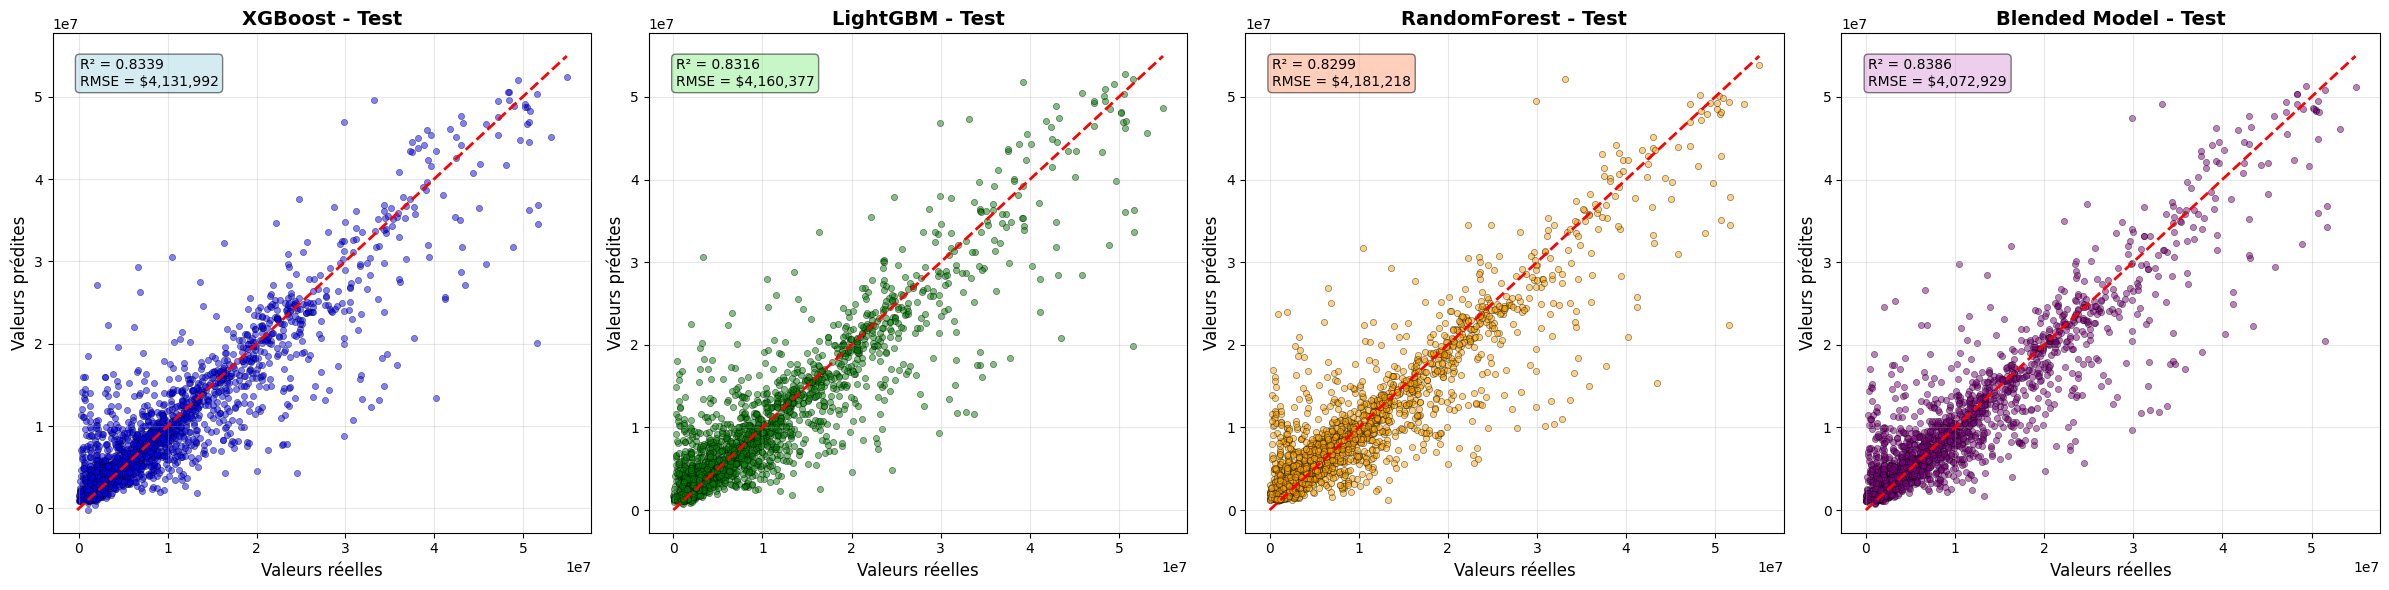

(<Figure size 2400x600 with 4 Axes>,
 array([<Axes: title={'center': 'XGBoost - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'LightGBM - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'RandomForest - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'Blended Model - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>],
       dtype=object))

In [33]:
from src.train_blended_model import plot_predictions, get_feature_importance, train_blended_model

model = train_blended_model(df_preprocessed)

get_feature_importance(model)

plot_predictions(model)

Comme prévu, on a un modèle extrêment performant grâce à la présence du salaire de l'année précédente dans les donnée. Dans le modèle **RandomForestRegresssor** il est quasiment 40x plus important que le second paramètre le plus important. 10x pour le **XGBoost** et 2x pour le **LightGBM**.

Essayons maintenant la même chose en enlevant le salaire de l'année précédente de la base de donnée pour essayer de trouver les déterminants de l'augmentation des salaires, s'il y en a.

Taille du jeu d'entraînement: 5100
Taille du jeu de test: 2187

Poids du blend: XGBoost=0.40, LightGBM=0.40, RandomForest=0.20

Entraînement du modèle XGBoost...
Entraînement du modèle LightGBM...
Entraînement du modèle RandomForest...

Blending des prédictions...

RÉSULTATS DES MODÈLES INDIVIDUELS

XGBoost:
   Train R²: 0.9188  |  Test R²: 0.7495
   Train RMSE: $2,701,647.71  |  Test RMSE: $5,074,612.43

LightGBM:
   Train R²: 0.8880  |  Test R²: 0.7526
   Train RMSE: $3,172,722.89  |  Test RMSE: $5,042,412.63

RandomForest:
   Train R²: 0.8919  |  Test R²: 0.7228
   Train RMSE: $3,117,061.50  |  Test RMSE: $5,337,368.88

RÉSULTATS DU MODÈLE BLENDÉ

Performance sur l'ensemble d'ENTRAÎNEMENT:
   R² Score:  0.9065
   RMSE:      $2,898,895.83
   MAE:       $2,103,708.45

Performance sur l'ensemble de TEST:
   R² Score:  0.7534
   RMSE:      $5,034,571.03
   MAE:       $3,448,792.25

Top 5 features - XGBoost:
         feature  importance
             PTS    0.486453
             YOE    0.

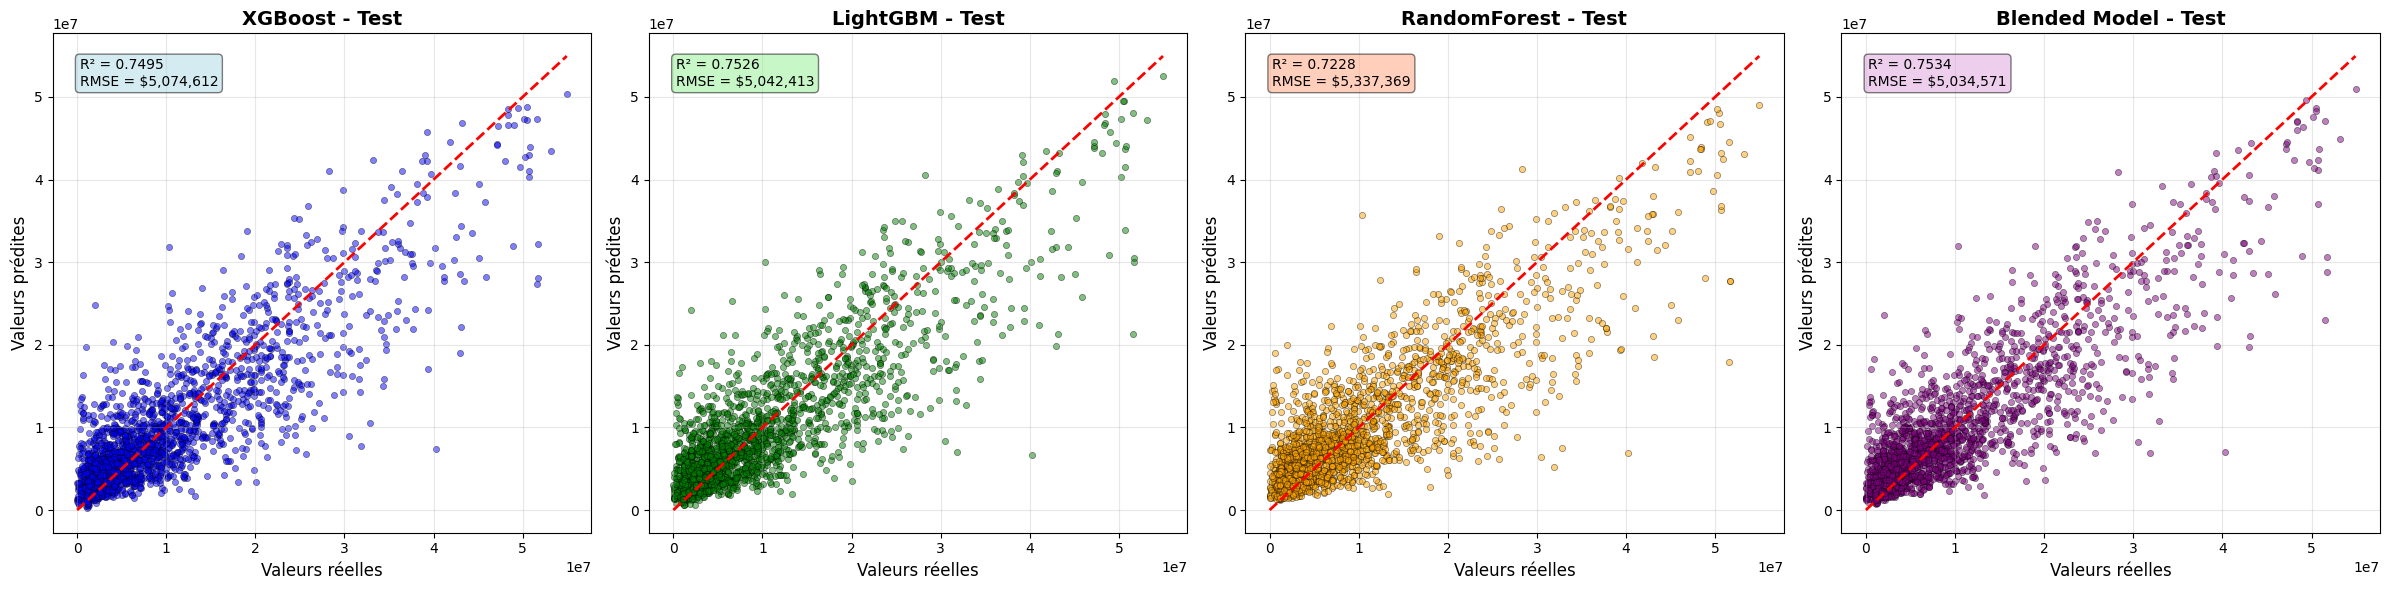

(<Figure size 2400x600 with 4 Axes>,
 array([<Axes: title={'center': 'XGBoost - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'LightGBM - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'RandomForest - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'Blended Model - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>],
       dtype=object))

In [34]:
columns_to_remove= [
        'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 
        'Team', 'Season', 'Year', 'Salary', 'Rank', 'adjusted_salary'
    ]

new_df_preprocessed, new_artifacts = preprocess_pipeline(df_clean, columns_to_remove=columns_to_remove, verbose=False)

new_model = train_blended_model(new_df_preprocessed)

get_feature_importance(new_model)

plot_predictions(new_model)

Le modèle obtenu est moins performant que le précédent, on perd environ 8 points sur le **R^2**. Mais elles restent tout de même très bonnes. De plus, il permet d'accéder des informations très précieuses sur les métriques de performance les plus importantes dans la prédiction de l'évolution des salaires, non-disponibles dans le modèle plus haut à cause de la présence du salaire de l'année passée. En effet : 

1. **XGBoost** et **RandomForest** privilégient la performance offensive des joueurs

Ces deux modèles s'accordent sur un constat simple : **en NBA, la performance offensive est le principal moteur financier**.

- Domination de **PTS** (Points) et **FGM** (Tirs réussis)
  Ces variables occupent les deux premières places avec un poids cumulé écrasant (plus de 50 % de l'importance totale chez XGBoost). C'est extrêmement cohérent avec la réalité du marché : les joueurs capables de marquer de manière constante sont ceux qui décrochent les plus gros contrats.

- **MIN** (Minutes jouées) 
  Présente dans le top 4 des deux modèles, cette variable indique qu'un temps de jeu élevé a un impact significatif sur l'évolution du salaire. Ceci est cohérent car le temps de jeu est synonyme de confiance de l'entraîneur, ce qui se traduit naturellement par une valeur marchande supérieure. De plus, plus de temps de jeu implique plus de visibilité auprès du public, donc plus de vente de maillots probablement.

- **YOE** (Years of Experience)  
  Elle reste une composante majeure, confirmant que l'ancienneté garantit des paliers de salaires plus élevés. Ceci est attendu car la NBA impose des grilles de salaire en fonction de l'expérience des joueurs dans la ligue.

2. LightGBM arrive à trouver un équilibre entre l'expérience et les performances du joueur sur le terrain, pas que offensives

En effet, le modèle **LightGBM** offre une vision beaucoup plus nuancée et moins centrée sur la performance offensive des joueurs. Les variables dans le top 5 des variables les plus significatifs ont des poids semblables, sans qu'il y en ait une plus prédominante que les autres. Les composantes principales sont : 

- Expérience et maturité (**YOE** et **AGE**)  
  Ce sont les deux variables les plus déterminantes, avec la même explication qu'au dessus avec la différence ici que se sont les composantes les plus importantes. Plus un joueur est âgé en NBA, plus il a de chance d'accéder au statut de Légende comme un Lebron James ou un Kobe Bryant.

- **TD3_RANK**, un critère de polyvalence
  Le classement en **Triple-Doubles** est aussi significatif que **YOE** et **AGE**. Cette variable est très pertinente car elle permet au modèle d'identifier les *Superstars* capables d'impacter tous les aspects du jeu (rebonds, passes, points), un profil très polyvalent souvent associé aux plus gros salaires.

- Performance (**MIN** & **PTS**) 
  Bien que ce modèle soit plus polyvalent que les précédents, il incorpore tout de même la performace offensive des joueurs ainsi que le nombre de minutes passées sur le terrain comme haut dessus, mais avec des poids beaucoup plus pondérés.


# Conclusion

Les résultats obtenus sont plutôt satisfaisants. La popularité du basketball et la richesse documentaire qui l'entoure ont facilité l'accès à des sources de données de qualité. Malgré le manque de données sur les salaires au début des années 2000, la base de données constituée est tout de même suffisamment robuste pour garantir la pertinence de nos analyses.

**Analyse descriptive et limites de la linéarité**

L'analyse descriptive initiale de l'évolution des rémunérations, mise en perspective avec les métriques de performance et l'expérience des joueurs, a permis de valider nos hypothèses de départ. Si la corrélation positive entre le score et le salaire est confirmée, tout comme l'impact favorable de l'expérience jusqu'à l'atteinte de l'apogée athlétique (prime), nous avons observé que cette relation n'est pas strictement linéaire. Poursuivant cette logique par des régressions linéaires, nous avons constaté que, bien que simplistes, ces modèles expliquent une part significative de la variance. À titre d'exemple, une régression linéaire simple corrélant le salaire ajusté à la moyenne de points inscrits explique à elle seule 40 % des disparités salariales. Toutefois, ce modèle échoue à capturer la nature convexe de cette relation : l'accroissement de la productivité offensive au-delà d'un certain seuil (~20 points) est une prouesse réservée à une élite, induisant une valorisation financière exponentielle pour chaque point supplémentaire.

**De la modélisation statistique au Machine Learning**

L'introduction d'une régression linéaire multiple (incluant points, rebonds, passes décisives, interceptions et contres) a légèrement affiné la précision des prédictions. Elle a surtout mis en exergue une divergence de valorisation entre les secteurs offensifs et défensifs : les statistiques défensives pèsent nettement moins sur les rémunérations, les interceptions semblant même corrélées négativement avec le salaire prédit dans ce cadre linéaire. Pour pallier les difficultés du modèle à prédire les plus hauts salaires et intégrer des variables non linéaires, nous avons implémenté des méthodes de Machine Learning plus modernes. Les performances des deux modèles « Blends » créés se révèlent particulièrement satisfaisantes : le premier modèle, intégrant le salaire de l'année précédente (ajusté à l'inflation), affiche une fiabilité remarquable sans overfitting ($R^2 = 0,84$ sur les données de test). S'il constitue un outil d'aide à la décision efficace pour les recruteurs, il occulte cependant l'impact des performances sportives sur la revalorisation salariale. Le second modèle, faisant abstraction du salaire passé, révèle des dynamiques structurelles intéressantes. Les algorithmes XGBoost et RandomForestRegressor privilégient une vision à court terme, où la domination offensive sur une seule saison dicte la rémunération future. À l'inverse, le modèle LightGBM propose une approche plus équilibrée : il accorde un poids prépondérant à l'expérience (vision à long terme) tout en intégrant la polyvalence du joueur sur la saison en cours.

**Synthèse**

En conclusion, en dépit des débats récurrents sur la cohérence des revenus en NBA, cette étude démontre que les salaires sont globalement en adéquation avec les performances mesurables. L'évolution des émoluments d'une saison à l'autre répond à une logique statistique identifiable, mêlant productivité immédiate et trajectoire de carrière. 

**Perspectives**

Bien que la part non expliquée de la variance des salaires soit probablement majoritairement due à des facteurs non liés à la performance, on peut également considérer que le problème ne réside pas tant dans l’absence de lien entre salaire et capacité, mais plutôt dans un manque d’outils permettant d’analyser avec un niveau de précision suffisant les réalisations sportives. Ces outils ne sont pas encore pleinement démocratisés, étant soit exclusivement utilisés par des plateformes spécialisées, soit tout simplement pas encore développés.

De nouveaux angles d’analyse émergent toutefois avec la place croissante des analyses statistiques auprès des amateurs de basket. À titre d’exemple, le partenariat lancé par la NBA avec AWS (Amazon Web Services) mettra à disposition, à partir de la saison 2025-26, quatre nouvelles statistiques : *le Defensive Box Score, le Play Finder, la métrique de difficulté des tirs et l’indice de gravité*.  
Ces nouvelles approches reposent sur un système de tracking de 29 points clés du corps des joueurs, enregistrés 60 fois par seconde, permettant d’analyser en continu l’impact d’un joueur sur le terrain. L’indice de gravité, par exemple, mesure l’attention portée par la défense adverse à un joueur : lorsqu’un double marquage est mis en place pour l’arrêter, cela libère l’un de ses coéquipiers et accroît ainsi son score de gravité.